# Machine Learning II
## Project 2024/25 
#### Work assembled by Guilherme Santos (202208081), Luana Letra (202208587) and Vítor Ferreira (201109428).

## Table of contents <a name="contents"></a>

1. [Introduction](#introduction)
2. [UrbanSound8K Dataset: Data Understanding](#dataset)
    - 2.1. [Tabular Data](#tabular)
    - 2.2. [Audio Data](#audio) 
3. [MLP: A classifier based on a multilayer perceptron](#mlp)
   - 3.1. [Data pre-processing and feature extraction](#mlp_data)
   - 3.2. [Model architecure](#mlp_model)
   - 3.3. [Training strategies](#mlp_training)
   - 3.4. [Performance evaluation](#mlp_performance) 

## 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

Research on urban acoustic environments is relatively limited. When available, it primarily focuses on classifying the type of auditory scene (e.g., street, park) rather than identifying specific sound sources within these scenes, such as a car horn, idling engine, or bird chirping. 

In this project, we will develop and evaluate **deep learning classifiers** specifically for urban sound classification using the **UrbanSound8K dataset**. The dataset contains labeled audio samples representing ten distinct urban sound classes. Aside from “children playing” and “gun shot,” which were included for variety, all other classes were chosen based on their high frequency in urban noise complaints. 

For this task, and according to the provided guideline, we have chosen to implement and compare three types of neural network architectures:

1. **Multilayer Perceptron (MLP)**

2. **Convolutional Neural Network (CNN)**

3. **Recurrent Neural Network (RNN)**

Our approach includes **data understanding** and **pre-processing steps (including feature extraction for each model)** to ensure consistent input formats.

For training, we will experiment with different strategies, including optimizers, learning rates, and regularization techniques, to fine-tune each model’s performance. We will evaluate each model using a **10-fold cross-validation** scheme on the UrbanSound8K dataset, analyzing performance through cumulative confusion matrices.

By comparing the three classifiers, we hope to gain a deeper understanding of how each architecture performs on audio classification tasks.

## 2. UrbanSound8K Dataset: Data Understanding <a name="dataset"></a>
[[go back to the top]](#contents)

In [2]:
import os
import soundata
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

The **UrbanSound8K** dataset provides a comprehensive collection of urban sound samples for audio classification research. It includes **8,732 audio clips** (each 4 seconds or shorter) representing **ten** urban sound classes:

- **air conditioner**
- **car horn**
- **children playing**
- **dog bark**
- **drilling**
- **engine idling**
- **gun shot**
- **jackhammer**
- **siren**
- **street music**

These classes are intended for the study and classification of urban acoustic events and are organized into **ten folds** to facilitate **cross-validation**.

The dataset contains **audio data** in **WAV format**. Each file varies in sampling rate, bit depth, and number of channels, as they are preserved from their original format on Freesound.org.

### 2.1 Tabular Data <a name="tabular"></a>
[[go back to the top]](#contents)

In addition to the audio files, the dataset includes a metadata file, **UrbanSound8k.csv**, which contains information about each audio clip. Key metadata features include:

- **slice_file_name**: The filename indicating Freesound ID, class ID, and occurrence details.
- **fsID**: The unique identifier for each sound on Freesound.
- **start** and **end** times: Time markers in the original Freesound recording.
- **salience**: A rating indicating the sound's prominence (foreground or background).
- **fold**: The fold number (1-10), aiding in consistent data partitioning.
- **classID** and **class**: Numeric and name identifiers for each sound class.

In [3]:
dataset = soundata.initialize('urbansound8k')
dataset.validate()  # validate that all the expected files are there
example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

100%|██████████████████████████████████████| 8732/8732 [00:11<00:00, 751.06it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


Clip(
  audio_path="/home/vitordrferreira/sound_datasets/urbansound8k/audio/fold7/43784-3-0-0.wav",
  clip_id="43784-3-0-0",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound

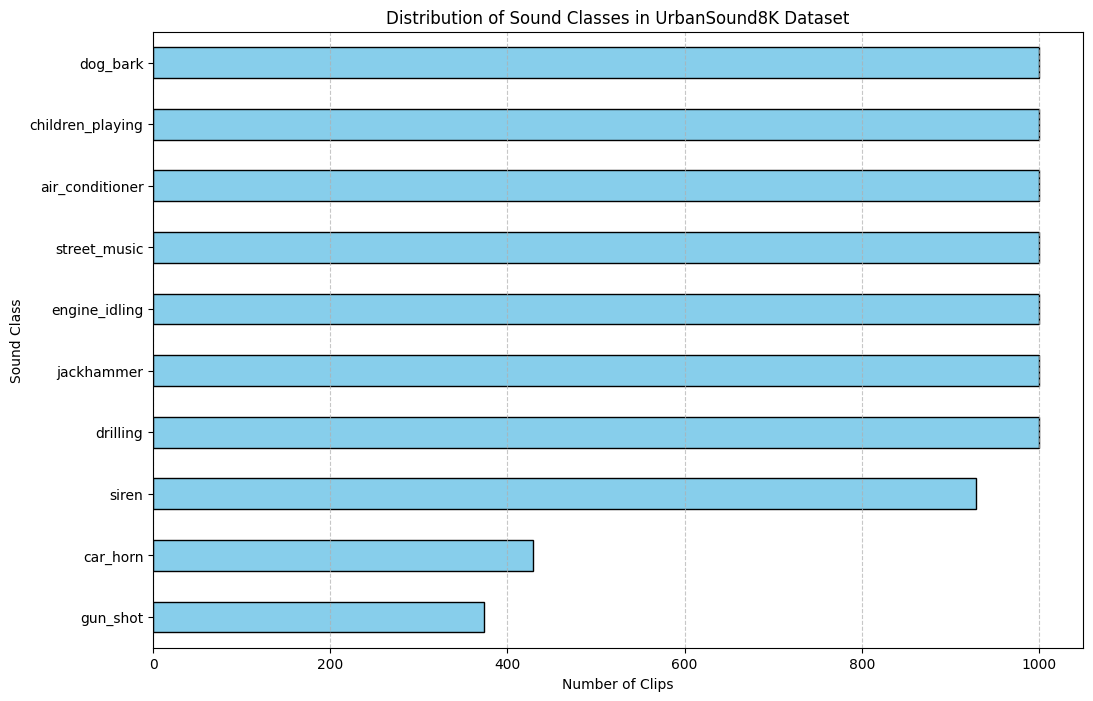

In [4]:
# Load the metadata file 
metadata_path = '/home/vitordrferreira/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv'  
metadata = pd.read_csv(metadata_path)

# Calculate the class distribution
class_distribution = metadata['class'].value_counts()

# Plotting the class distribution 
plt.figure(figsize=(12, 8))
class_distribution.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Number of Clips')
plt.ylabel('Sound Class')
plt.title('Distribution of Sound Classes in UrbanSound8K Dataset')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

As seen above, the class distribution in the UrbanSound8K dataset is **fairly well-balanced**, with most sound classes containing a similar number of clips. This balance is beneficial for training machine learning models, as it helps prevent bias towards any particular sound class. However, **"car_horn"** and **"gun_shot"** have noticeably fewer clips compared to other classes, which could make it more challenging for models to accurately recognize these sounds.

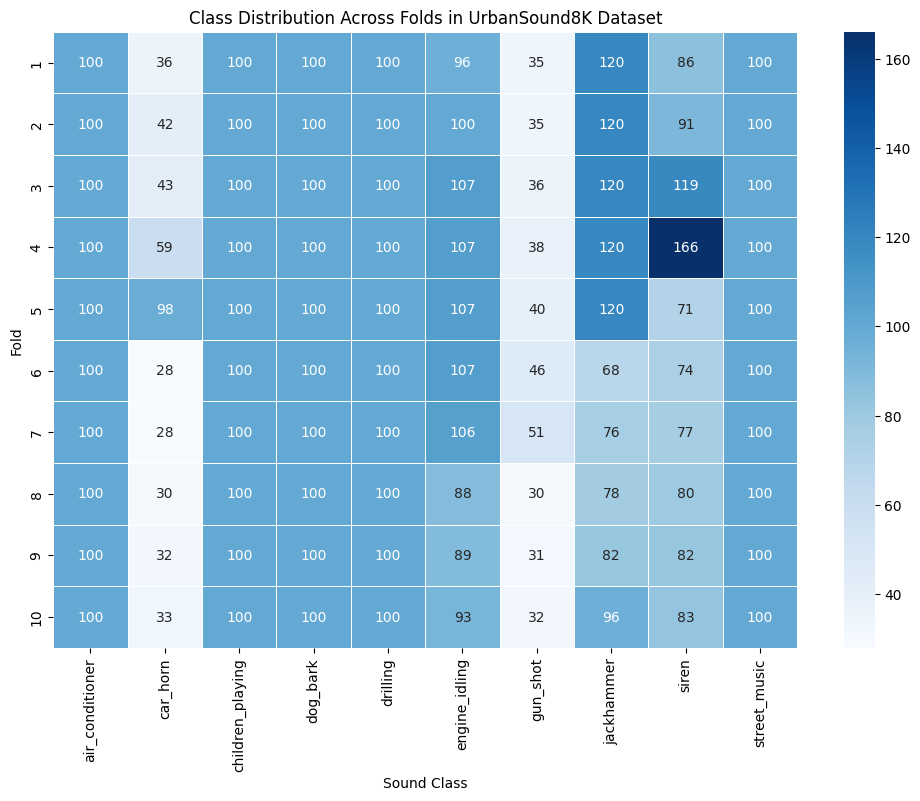

In [5]:
# Calculate the class distribution for each fold
fold_class_distribution = metadata.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Set up the figure and plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(fold_class_distribution, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)
plt.title('Class Distribution Across Folds in UrbanSound8K Dataset')
plt.xlabel('Sound Class')
plt.ylabel('Fold')
plt.show()

Some additional observations:

- The dataset is **relatively balanced** across most **classes and folds**, with most cells showing similar counts around 100 samples per class.
- Certain classes, like **"car_horn"** and **"gun_shot"**, have noticeably lower sample counts across all folds, indicating that they are underrepresented compared to other classes.
- The **"siren"** class has a high count of 166 samples in Fold 4, which seens a clear **outlier** compared to other folds for this class.

In [6]:
# Define a tolerance for floating-point comparison
tolerance = 1e-6

# Calculate duration by subtracting start time from end time
metadata['duration'] = metadata['end'] - metadata['start']

# Identify files that exceed the 4-second duration, strictly greater than 4 seconds
exceeding_files = metadata[(metadata['duration'] - 4) > tolerance]

if exceeding_files.empty:
    print("All files have a duration of 4 seconds or less.")
else:
    print("Some files exceed the 4-second duration:")
    print(exceeding_files[['slice_file_name', 'duration']])

All files have a duration of 4 seconds or less.


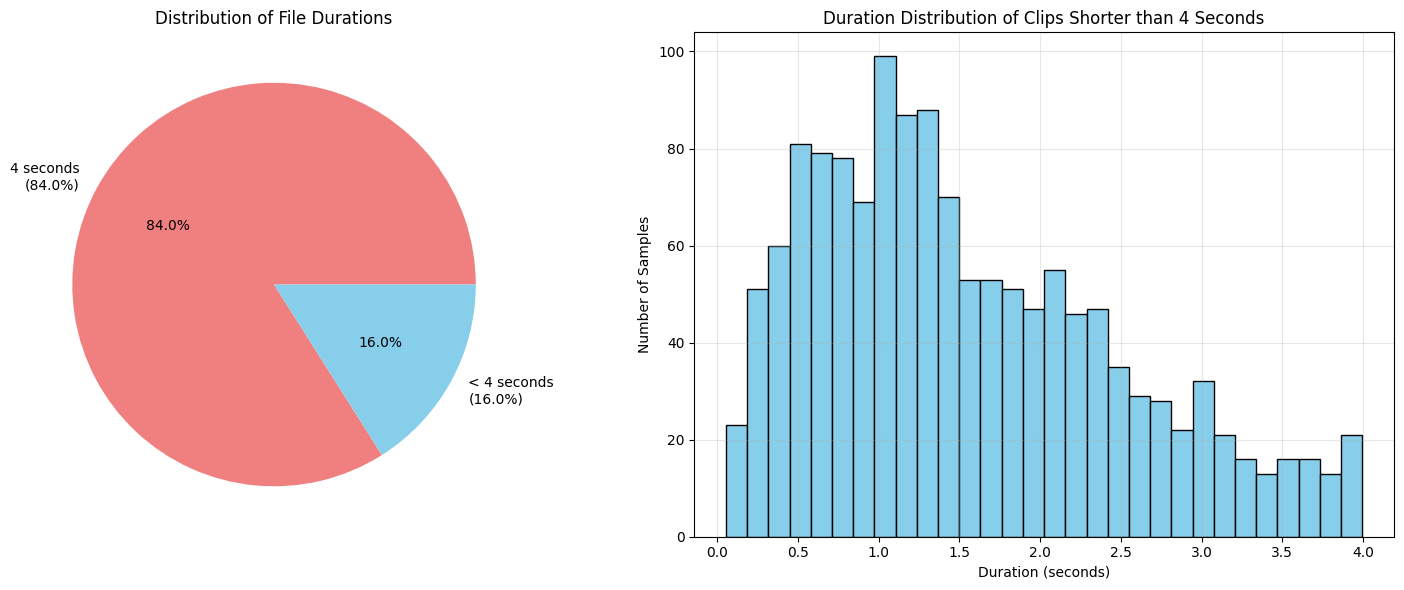

Duration Analysis:
Total number of files: 8732
Files exactly 4 seconds (±1e-06s): 7333 (84.0%)
Files shorter than 4 seconds: 1399 (16.0%)


In [7]:
# Calculate files exactly 4 seconds (within tolerance)
exactly_4s = metadata[abs(metadata['duration'] - 4.0) <= tolerance]
# Calculate files shorter than 4 seconds (with tolerance)
shorter_files = metadata[metadata['duration'] - 4.0 < -tolerance]  

# Calculate statistics
total_files = len(metadata)
percent_4s = (len(exactly_4s) / total_files) * 100
percent_shorter = (len(shorter_files) / total_files) * 100

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Pie chart showing proportion of 4s vs shorter files
sizes = [len(exactly_4s), len(shorter_files)]
labels = [f'4 seconds\n({percent_4s:.1f}%)', f'< 4 seconds\n({percent_shorter:.1f}%)']
colors = ['lightcoral', 'skyblue']

ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax1.set_title('Distribution of File Durations')

# Plot 2: Histogram of shorter files
ax2.hist(shorter_files['duration'], bins=30, color='skyblue', edgecolor='black')
ax2.set_title('Duration Distribution of Clips Shorter than 4 Seconds')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Number of Samples')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print exact numbers
print("Duration Analysis:")
print(f"Total number of files: {total_files}")
print(f"Files exactly 4 seconds (±{tolerance}s): {len(exactly_4s)} ({percent_4s:.1f}%)")
print(f"Files shorter than 4 seconds: {len(shorter_files)} ({percent_shorter:.1f}%)")

To better understand the **temporal characteristics** of our dataset, we analyzed the duration of audio clips. While the dataset documentation specifies that all clips are less than or equal to 4 seconds (which we confirmed), our analysis reveals a more nuanced distribution:

- **84%** of the audio clips are exactly 4 seconds long (±1e-6 seconds tolerance for floating-point precision);
- The remaining **16%** are shorter than 4 seconds;
- The histogram of shorter clips shows an interesting distribution with:
  - A peak around 1-1.5 seconds;
  - A gradual decrease in frequency as duration increases;
  - Some very short clips (< 0.5 seconds);

This **duration variability** is important to consider for our **pre-processing strategy**, as we'll need to handle clips of different lengths in a consistent way.

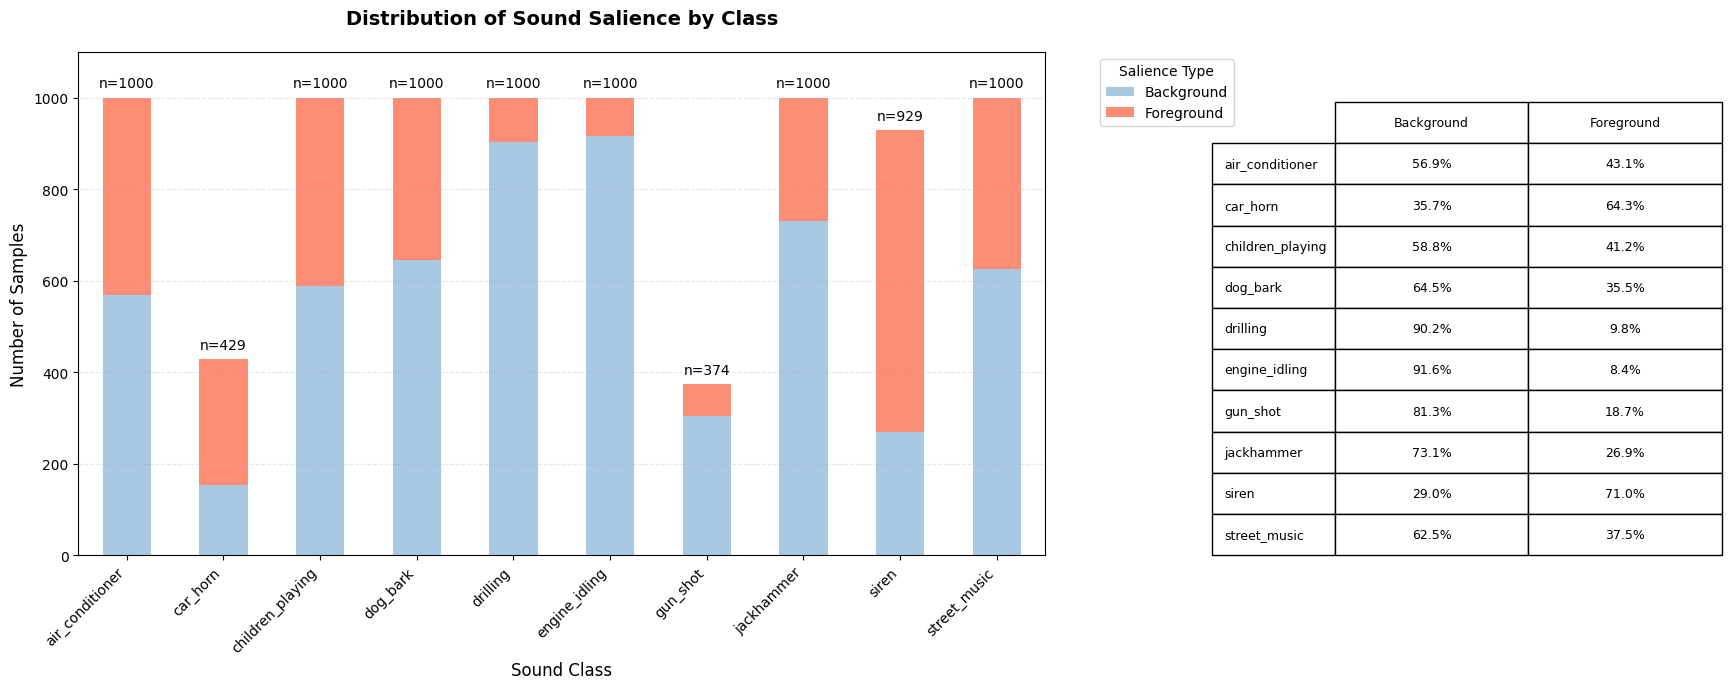

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Analyze salience distribution
salience_dist = pd.crosstab(metadata['class'], metadata['salience'])
salience_dist.columns = ['Background', 'Foreground']

# Calculate percentages
salience_pct = salience_dist.div(salience_dist.sum(axis=1), axis=0) * 100

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate total counts per class for annotation
totals = salience_dist.sum(axis=1)

# Set y-axis limit for the plot
y_max = max(totals) + 100  # Increase the upper limit to give more space

# Create stacked bar plot
salience_dist.plot(kind='bar', stacked=True, 
                   color=['#a8c8e4', '#fd8d75'],  
                   ax=ax)

# Customize plot
plt.title('Distribution of Sound Salience by Class', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Sound Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Set y-axis limits
plt.ylim(0, y_max)

# Add total count annotations with some space above each bar
for i, total in enumerate(totals):
    plt.text(i, total + (y_max * 0.02), f'n={total}', ha='center', fontsize=10)

# Add horizontal grid lines only
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Customize legend
plt.legend(title='Salience Type', 
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=True)

# Rotate x-labels and align them
plt.xticks(rotation=45, ha='right')

# Create a percentage table
cell_text = []
for idx in salience_pct.index:
    cell_text.append([f'{salience_pct.loc[idx, "Background"]:.1f}%',
                      f'{salience_pct.loc[idx, "Foreground"]:.1f}%'])

# Add table
table = plt.table(cellText=cell_text,
                  rowLabels=salience_pct.index,
                  colLabels=['Background', 'Foreground'],
                  bbox=[1.3, 0.0, 0.4, 0.9],
                  cellLoc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Adjust layout to accommodate the table
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


The dataset includes a salience rating for each sound clip, indicating whether the sound appears in the **foreground (1)** or **background (2)** of the recording. This analysis reveals interesting patterns:
   - Sudden, alert-type sounds (car_horn, siren) tend to be foreground events;
   - Continuous, ambient sounds (drilling, engine_idling) are typically background noise;
   - Some classes like children_playing and air_conditioner show a more balanced distribution;

This salience distribution is important for our classification task as it suggests that:
- Some sounds may be easier to classify due to their prominence in recordings;
- Background sounds might require more sophisticated feature extraction to capture their characteristics;

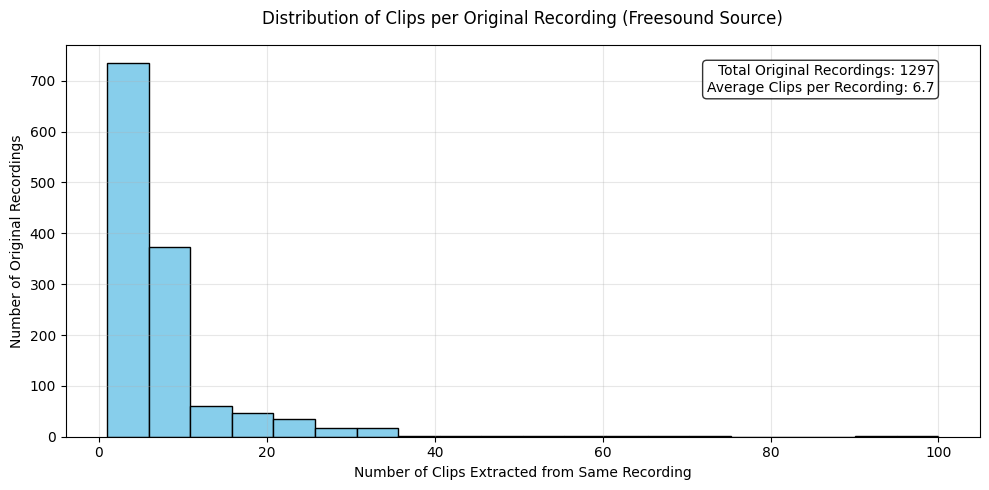

In [9]:
# Count how many clips come from the same original recording
fsid_counts = metadata.groupby('fsID').size()

# Create a simple figure
plt.figure(figsize=(10, 5))
plt.hist(fsid_counts, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Clips per Original Recording (Freesound Source)', pad=15)
plt.xlabel('Number of Clips Extracted from Same Recording')
plt.ylabel('Number of Original Recordings')
plt.grid(True, alpha=0.3)

# Add a simple text box with key statistics
stats_text = (f"Total Original Recordings: {len(fsid_counts)}\n"
             f"Average Clips per Recording: {fsid_counts.mean():.1f}")
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

The analysis of **Freesound IDs (fsID)** reveals that the 8732 audio clips in the dataset were extracted from **1297 unique original recordings**. On average, around 7 clips were extracted from each original recording, although the distribution is highly skewed: many recordings contributed just a few clips, while a small number of recordings provided many clips. 

In summary, after analyzing the metadata of the UrbanSound8K dataset, we gained several important insights:

1. **Class Distribution**:
  - The dataset contains 8732 audio clips across 10 urban sound classes;
  - Most classes have approximately 1000 samples each;
  - Notable exceptions are "car_horn" and "gun_shot", which are underrepresented;

2. **Duration Characteristics**:
  - All audio clips are ≤ 4 seconds in length;
  - 84% of clips are exactly 4 seconds long;
  - 16% of clips have varying durations below 4 seconds;
  - This duration variability will need to be addressed in our preprocessing strategy;

3. **Salience Distribution**:
  - Each clip is labeled as either foreground (1) or background (2);
  - Some classes are predominantly foreground sounds (e.g., car horns, sirens);
  - Others are mainly background sounds (e.g., drilling, engine idling);
  - This variation in salience might affect the ease of classification for different classes;

4. **Source Recordings**:
  - The 8732 clips originate from 1297 unique Freesound recordings;
  - Average of 7 clips per original recording;
  - High variability in clips per recording (from 1 to many clips);

5. **Dataset Organization**:
  - Pre-divided into 10 folds for cross-validation;
  - Folds usually maintain similar class distributions;

Thus, these characteristics will inform our preprocessing decisions and modeling strategy for the classification task.

### 2.2 Audio Data <a name="audio"></a>
[[go back to the top]](#contents)

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


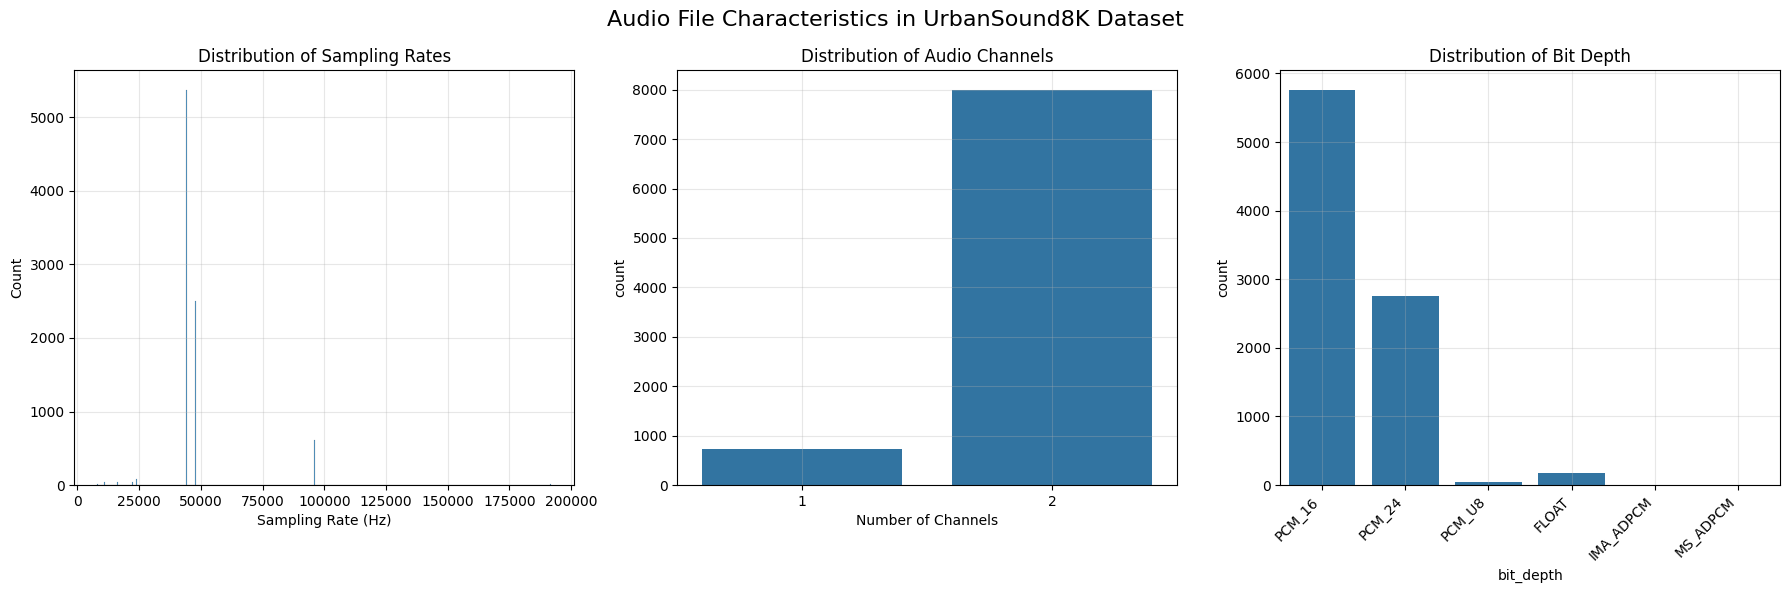


Audio Characteristics Summary:

Sampling Rates:
sample_rate
8000        12
11024        7
11025       39
16000       45
22050       44
24000       82
32000        4
44100     5370
48000     2502
96000      610
192000      17
Name: count, dtype: int64

Number of Channels:
channels
2    7993
1     739
Name: count, dtype: int64

Bit Depths:
bit_depth
PCM_16       5758
PCM_24       2753
FLOAT         169
PCM_U8         43
MS_ADPCM        8
IMA_ADPCM       1
Name: count, dtype: int64


In [10]:
def get_audio_characteristics(file_path):
   try:
       info = sf.info(file_path)
       return {
           'sample_rate': info.samplerate,
           'channels': info.channels,
           'bit_depth': info.subtype
       }
   except Exception as e:
       print(f"Error processing {file_path}: {str(e)}")
       return None

# Initialize lists to store characteristics
characteristics = []

# Analyze files
for _, row in metadata.iterrows():
   file_path = os.path.join('/home/vitordrferreira/sound_datasets/urbansound8k/audio', 
                           f'fold{row["fold"]}', 
                           row['slice_file_name'])
   
   chars = get_audio_characteristics(file_path)
   if chars:
       chars['class'] = row['class']
       characteristics.append(chars)

# Convert to DataFrame for easier analysis
df_chars = pd.DataFrame(characteristics)

# Create visualizations with 3 subplots instead of 4
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Changed to 1x3 layout
fig.suptitle('Audio File Characteristics in UrbanSound8K Dataset', fontsize=16)

# 1. Sampling Rate Distribution
sns.histplot(data=df_chars, x='sample_rate', ax=axes[0])
axes[0].set_title('Distribution of Sampling Rates')
axes[0].set_xlabel('Sampling Rate (Hz)')
axes[0].grid(True, alpha=0.3)

# 2. Number of Channels
sns.countplot(data=df_chars, x='channels', ax=axes[1])
axes[1].set_title('Distribution of Audio Channels')
axes[1].set_xlabel('Number of Channels')
axes[1].grid(True, alpha=0.3)

# 3. Bit Depth Distribution
bit_depth_plot = sns.countplot(data=df_chars, x='bit_depth', ax=axes[2])
axes[2].set_title('Distribution of Bit Depth')
axes[2].set_xticks(axes[2].get_xticks())
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAudio Characteristics Summary:")
print("\nSampling Rates:")
print(df_chars['sample_rate'].value_counts().sort_index())
print("\nNumber of Channels:")
print(df_chars['channels'].value_counts())
print("\nBit Depths:")
print(df_chars['bit_depth'].value_counts())

After examining the audio files in the UrbanSound8K dataset, we found **significant variations** in their technical specifications:

1. **Sampling Rates**:
  - Range: 8000 Hz to 192000 Hz;
  - The variety of sampling rates suggests we need standardization in our preprocessing pipeline;

2. **Channel Configuration**:
  - Majority are stereo (7993 files);
  - Only 739 files are mono;

3. **Bit Depth**:
  - Predominant formats:
    - PCM_16 (5758 files); 
    - PCM_24 (2753 files); 
  - Some files use floating-point representation (FLOAT, 169 files)
  - Few files use specialized formats (MS_ADPCM, IMA_ADPCM)

Before proceeding with feature extraction, it is also crucial to understand the characteristics of our audio data through visual inspection. We analyze three fundamental representations of audio signals for each class in our UrbanSound8K dataset:

1. **Waveform (Time Domain)**:
  - Shows the amplitude variation of the sound over time;
  - Helps identify temporal patterns, silence periods, and overall signal intensity;
  - Particularly useful for observing periodic patterns (like sirens) or impulsive sounds (like gunshots);

2. **Spectrogram**:
  - Represents the frequency content of the signal over time,
  - Created using Short-Time Fourier Transform (STFT);
  - Brighter colors indicate stronger frequency components;

3. **Mel-spectrogram**:
  - A spectrogram with frequency bins mapped to the Mel scale;
  - More closely matches human auditory perception;
  - Reduces the dimensionality while preserving perceptually important information;

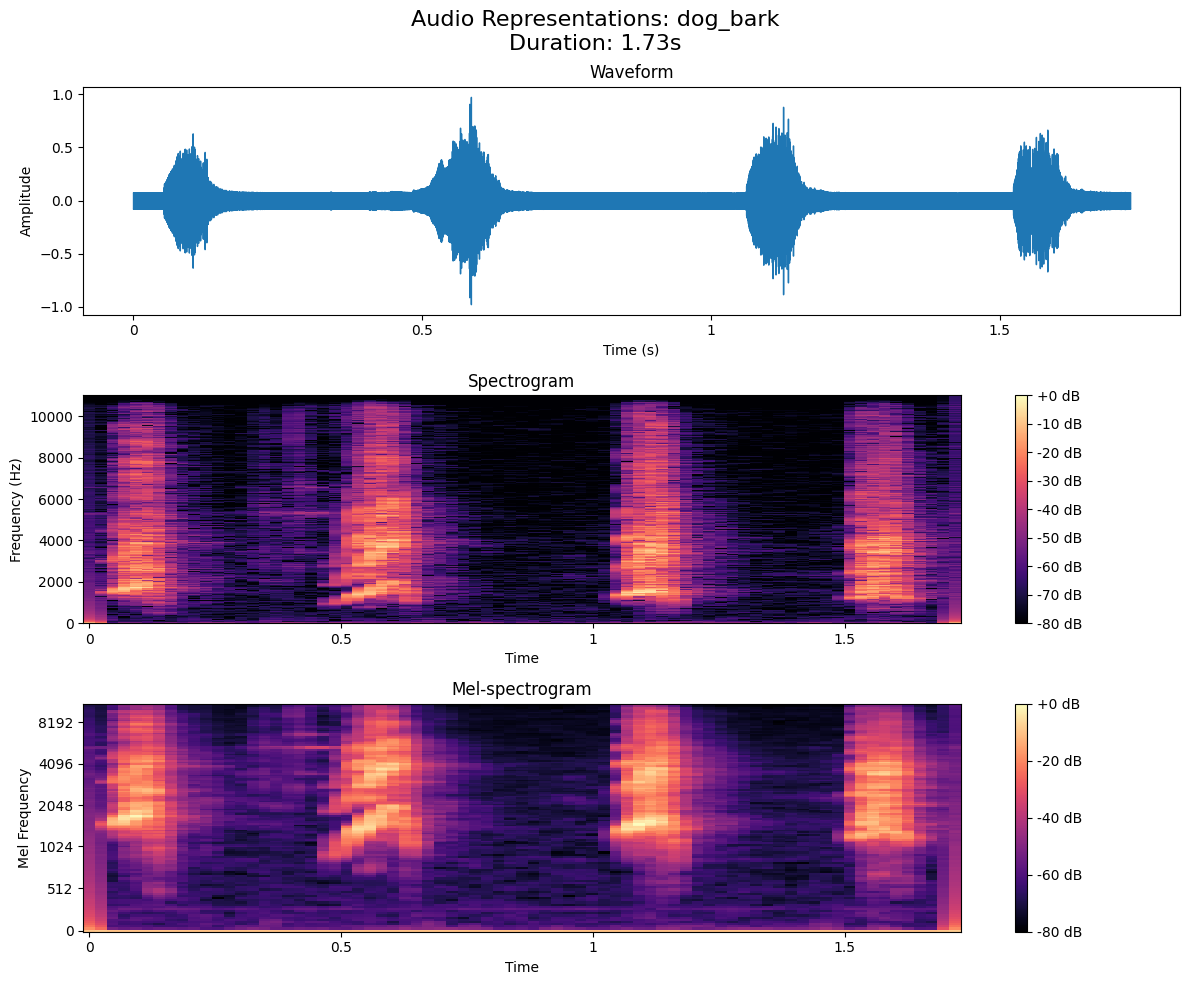

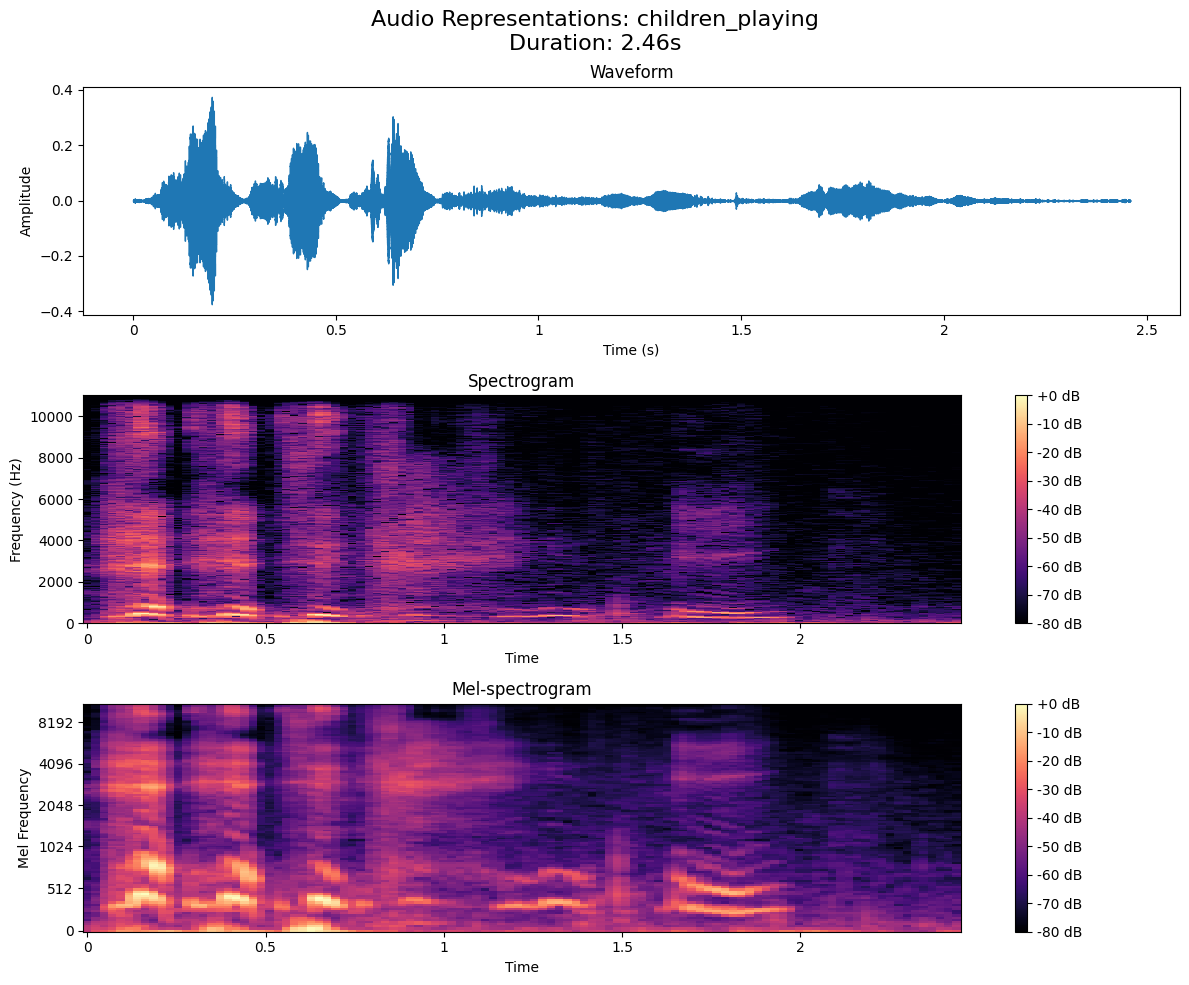

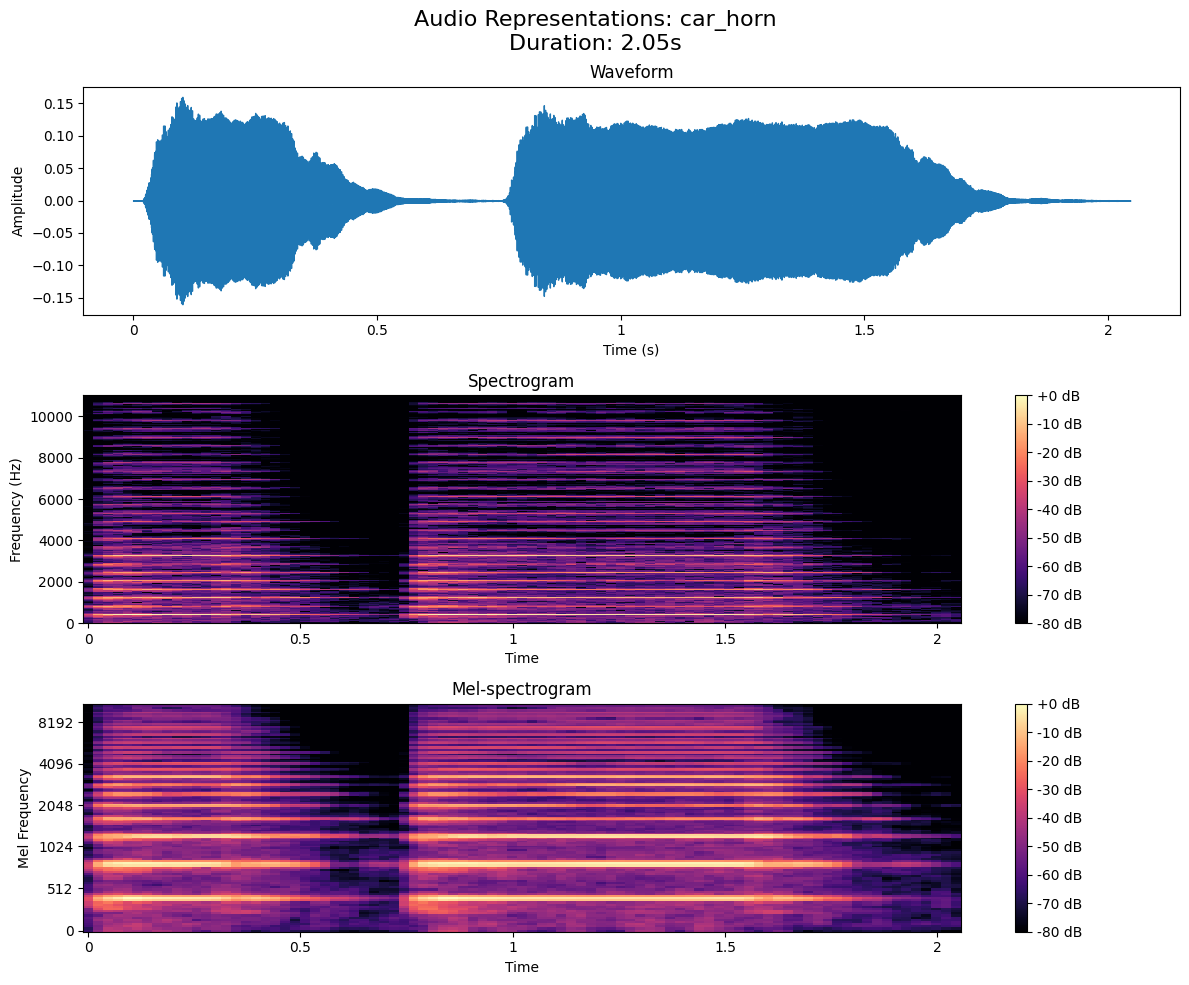

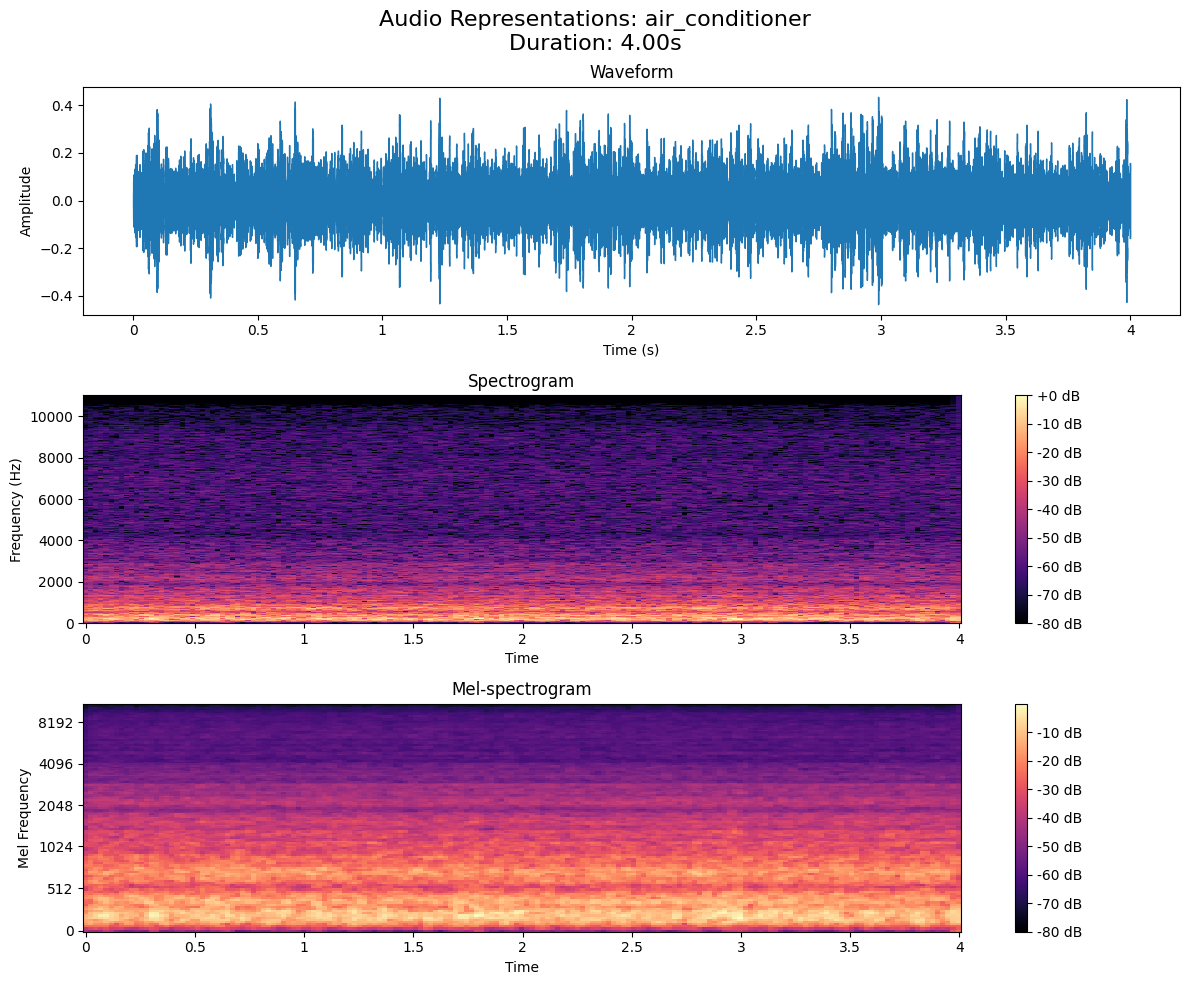

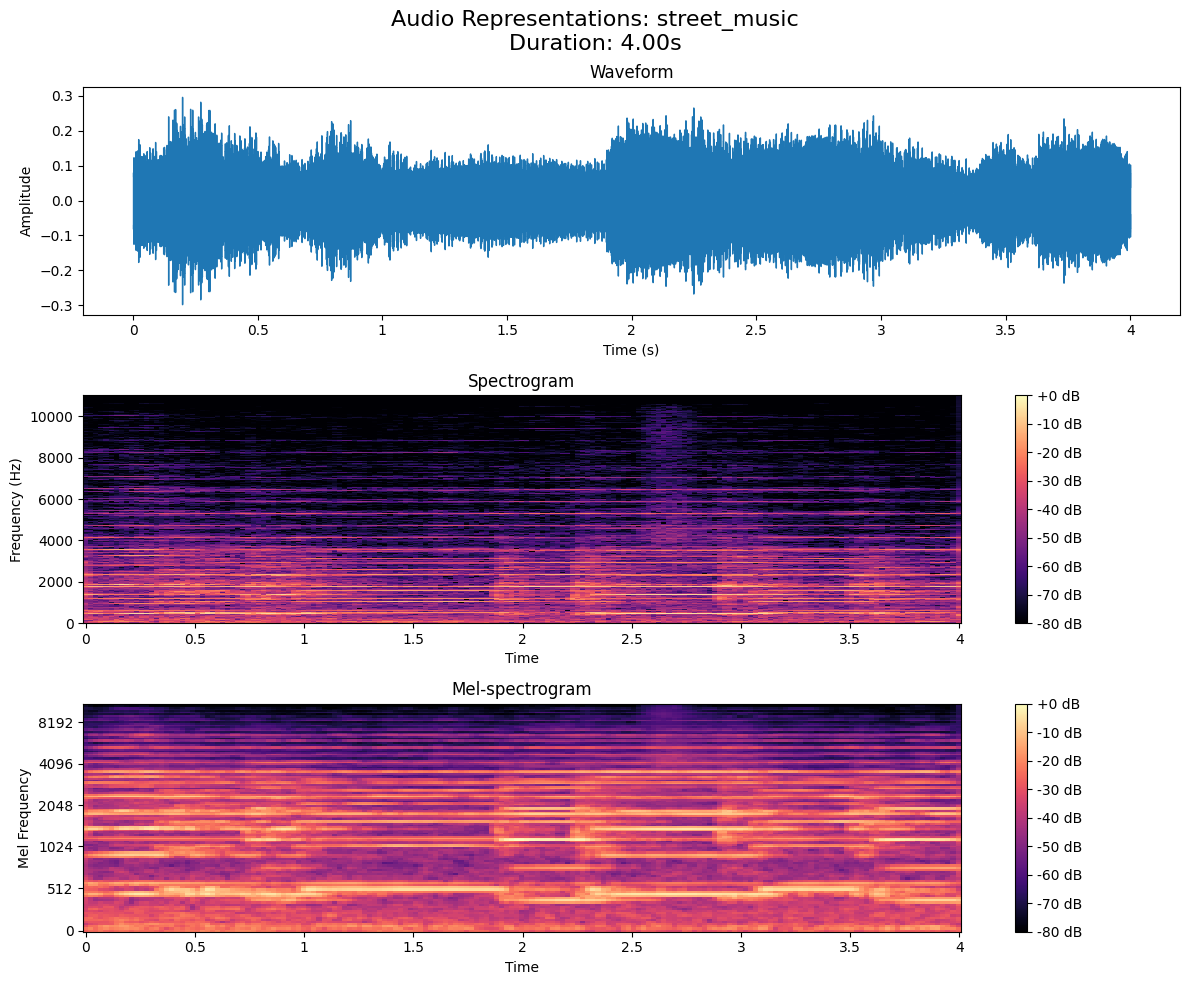

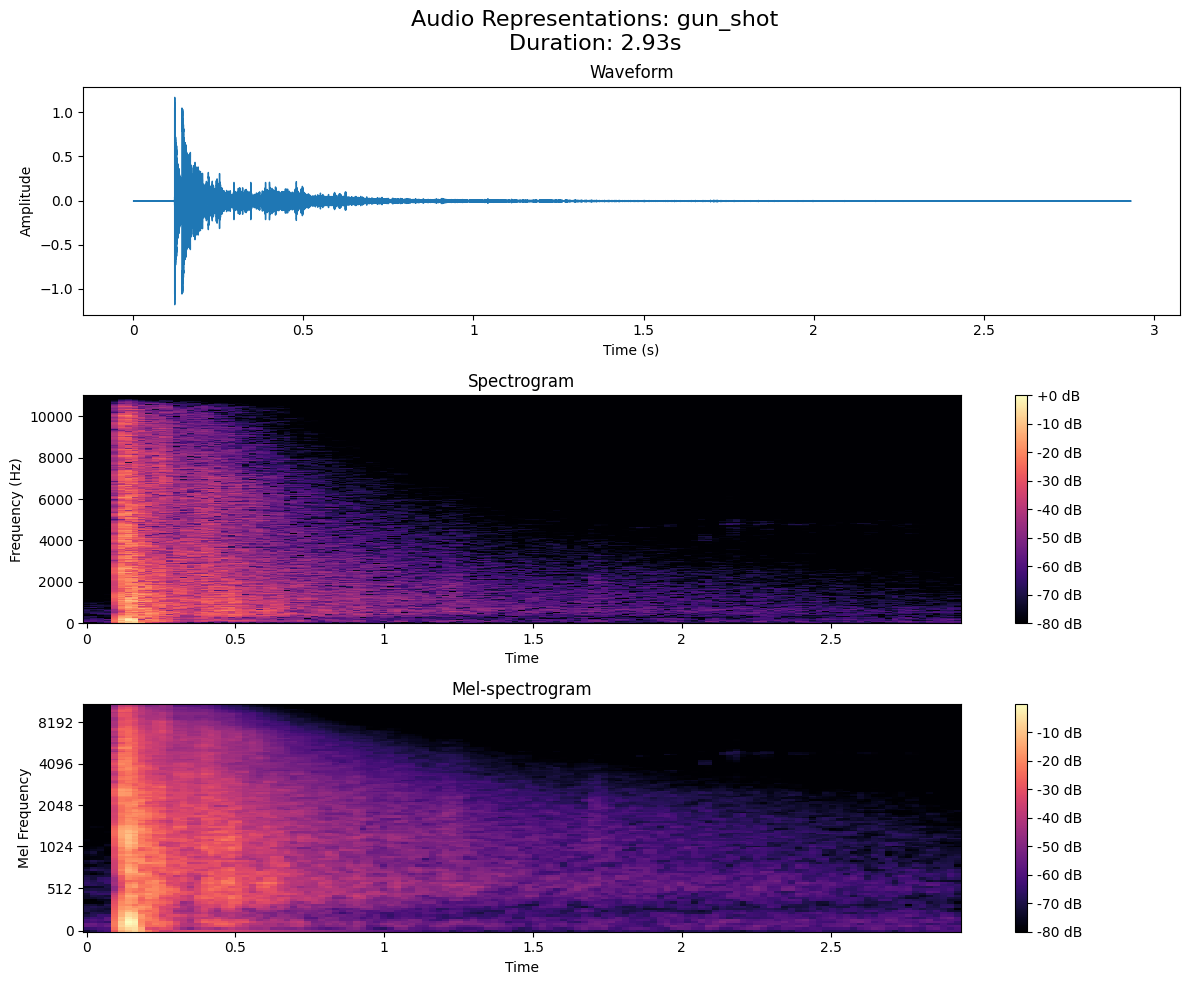

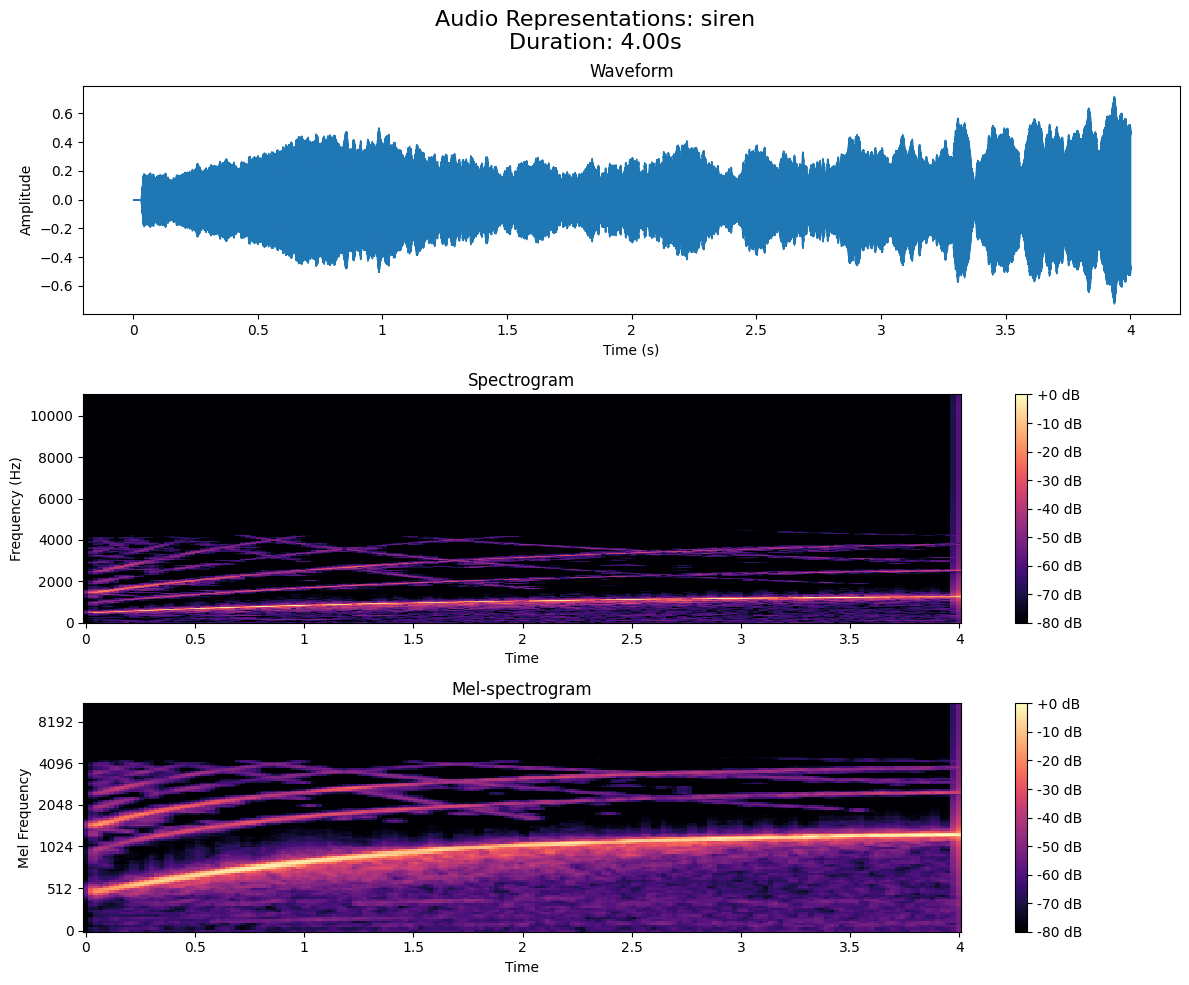

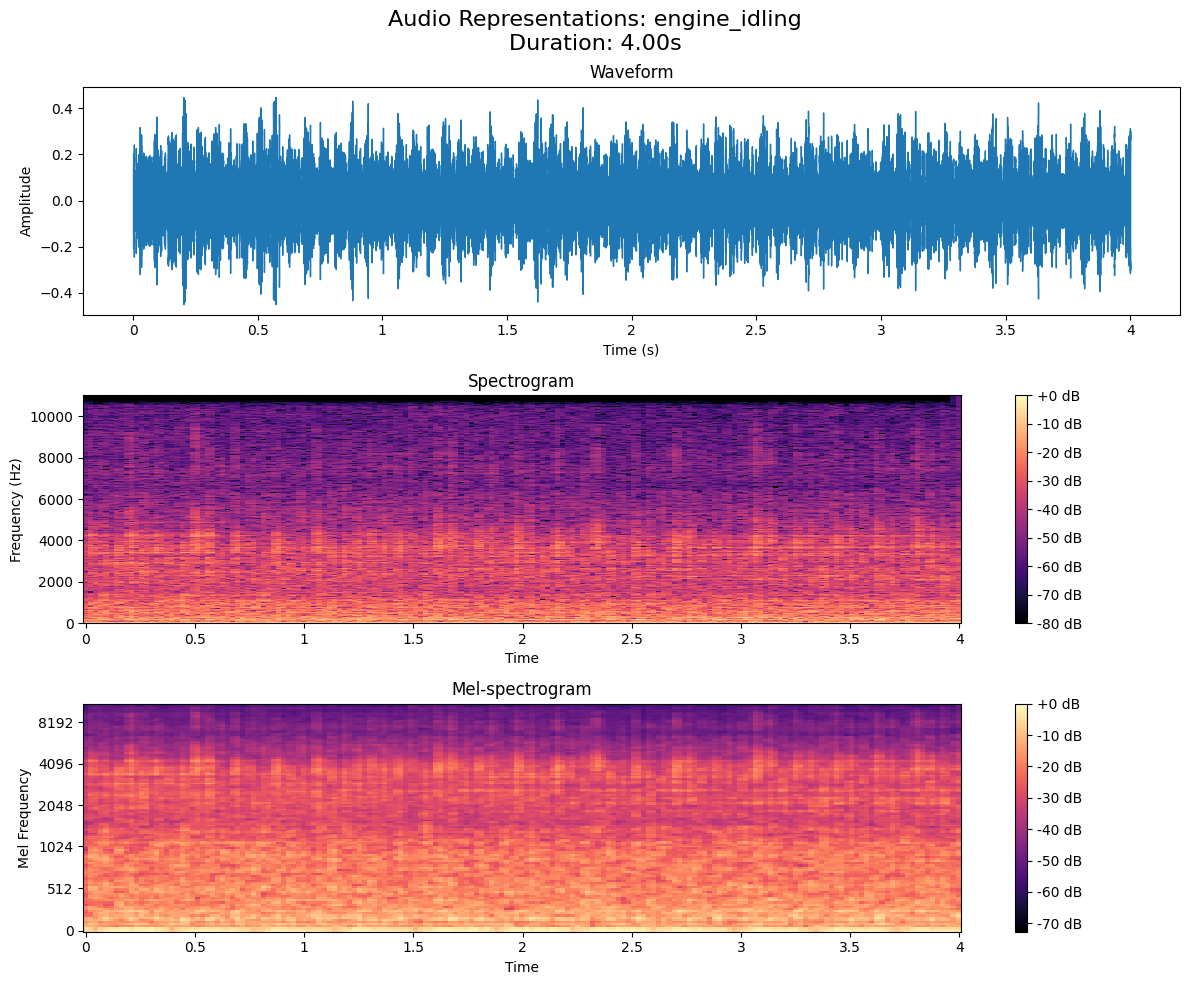

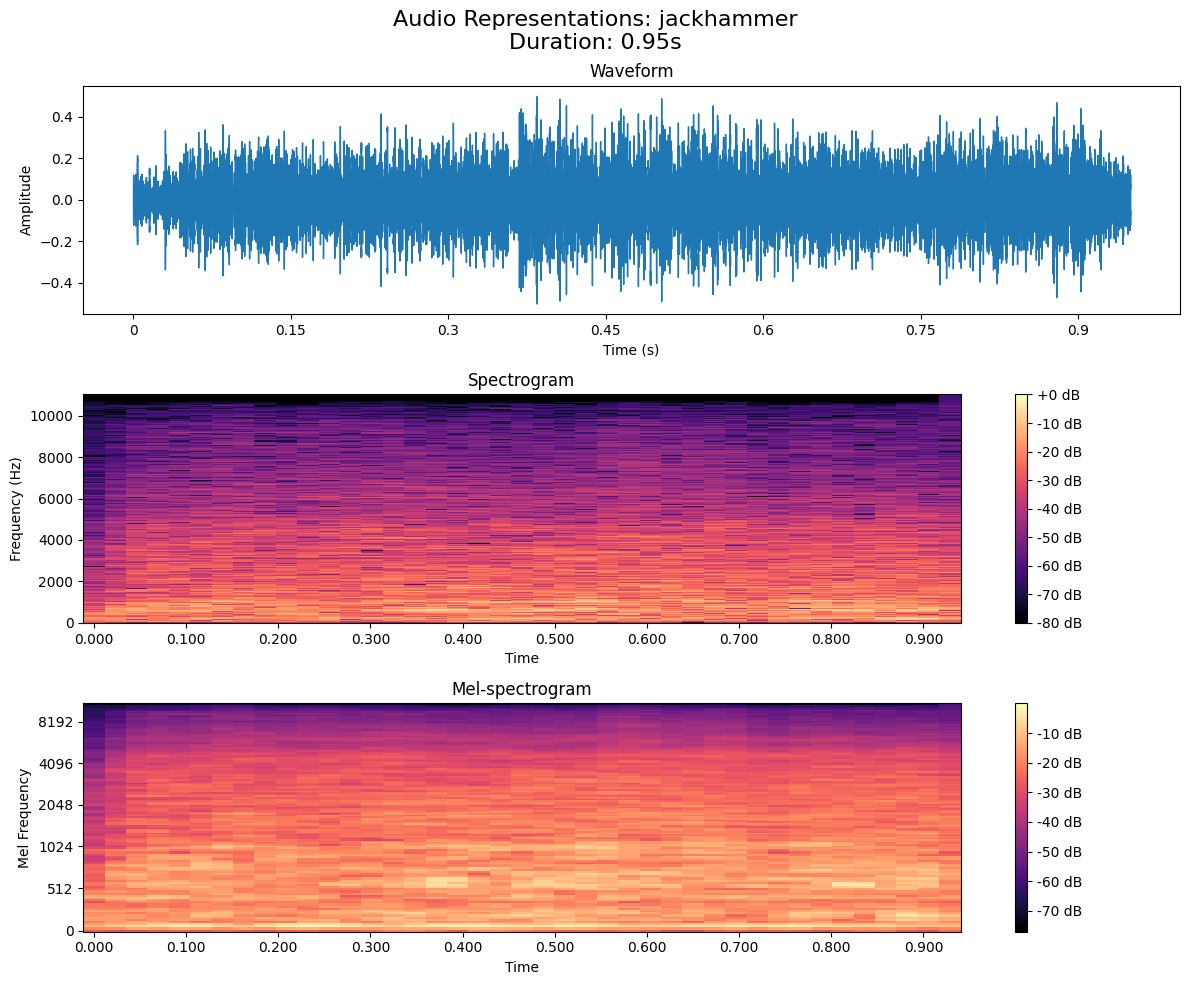

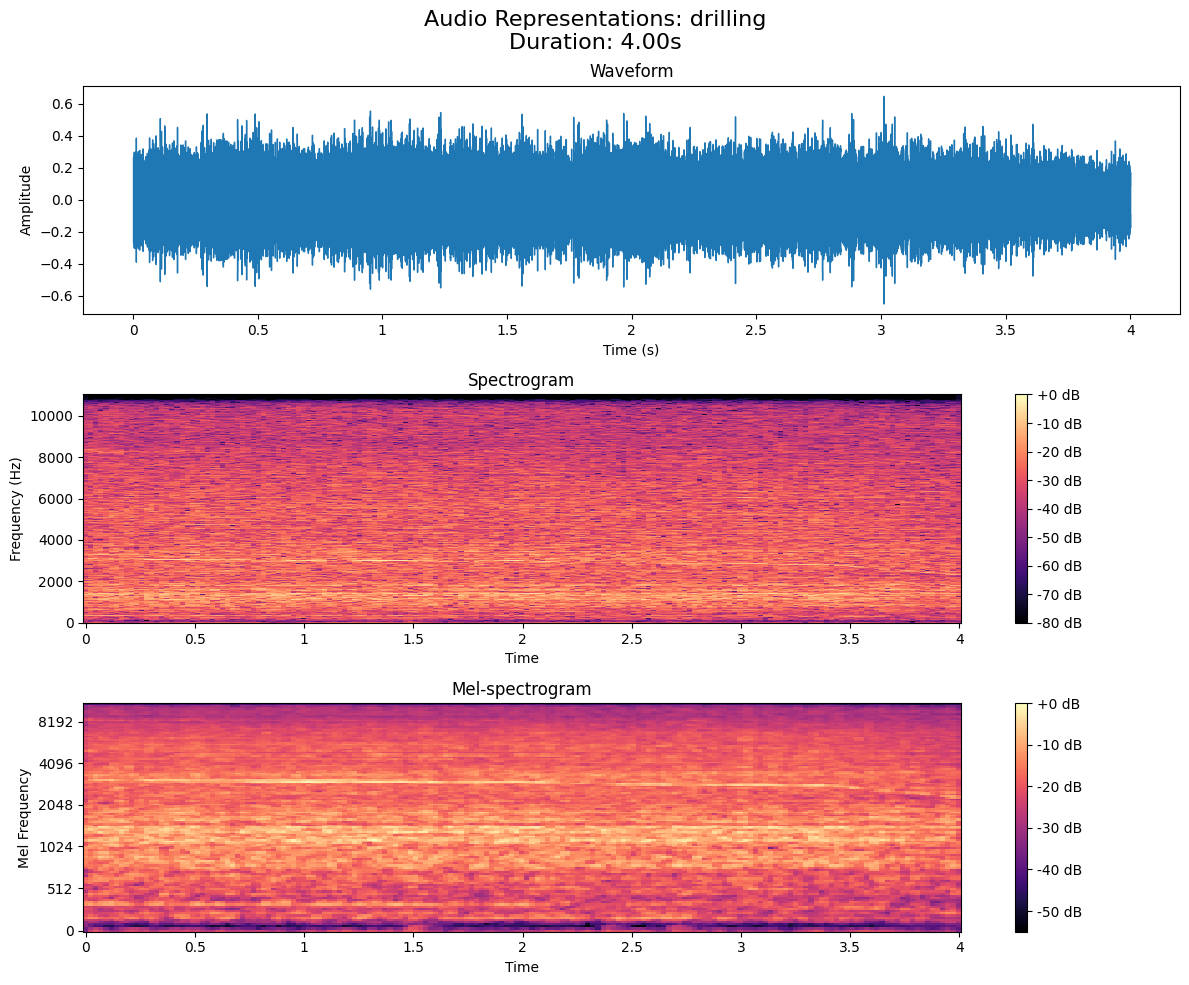

In [11]:
def plot_audio_representations(file_path, title):
    # Load audio file
    y, sr = librosa.load(file_path, sr=22050)  # Fixed sampling rate
    duration = len(y) / sr  # Calculate duration
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    fig.suptitle(f'Audio Representations: {title}\nDuration: {duration:.2f}s', fontsize=16)
    
    # 1. Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title('Waveform')
    axes[0].set_xlabel('Time (s)')  
    axes[0].set_ylabel('Amplitude')
    
    # 2. Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', 
                                 sr=sr, ax=axes[1])
    axes[1].set_title('Spectrogram')
    axes[1].set_ylabel('Frequency (Hz)') 
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # 3. Mel-spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    img = librosa.display.specshow(mel_spect_db, y_axis='mel', x_axis='time', 
                                 sr=sr, ax=axes[2])
    axes[2].set_title('Mel-spectrogram')
    axes[2].set_ylabel('Mel Frequency')  
    fig.colorbar(img, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

# Sample one file from each class ensuring we get foreground samples if possible
np.random.seed(42)  # for reproducibility
for class_name in metadata['class'].unique():
    # Try to get a foreground sample first (salience=1)
    class_files = metadata[metadata['class'] == class_name]
    foreground_files = class_files[class_files['salience'] == 1]
    
    if not foreground_files.empty:
        sample_row = foreground_files.sample(n=1).iloc[0]
    else:
        sample_row = class_files.sample(n=1).iloc[0]
    
    file_path = os.path.join('/home/vitordrferreira/sound_datasets/urbansound8k/audio', 
                            f'fold{sample_row["fold"]}', 
                            sample_row['slice_file_name'])
    
    plot_audio_representations(file_path, class_name)

## 3. MPL: A classifier based on a multilayer perceptron <a name="mlp"></a>
### 3.1. Data pre-processing and feature extraction <a name="mlp_data"></a>
[[go back to the top]](#contents)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

For our **Multi-Layer Perceptron (MLP)** classifier, we need to convert variable-length audio signals into fixed-length feature vectors. This section details our pre-processing and feature extraction strategy.

**Sampling Rate Standardization**
- 44100 Hz is the most common rate in our dataset;
- However, 22050 Hz should be sufficient for our urban sound classification task while reducing data size;

**Audio Duration Handling**
- Strategy for shorter clips: zero-padding to 4 seconds;
- Preserves temporal location of sound events while maintaining fixed-length input;

**Channel Standardization**
- Convert all audio to mono;
- Urban sound classification typically doesn't benefit from stereo information;
- Reduces computational complexity;

Furthermore, we decided to extract the following **features**:

- **RMS and ZCR (Zero Crossing Rate)**: rms_mean, rms_std, zcr_mean, and zcr_std, as they capture the intensity and noisiness of the audio signal, which are often distinguishing factors across sound classes.
- **Spectral Features**: Including centroid, bandwidth, rolloff, and flatness because they capture different aspects of the sound spectrum and are known to be effective for classifying sound types.
- **MFCCs**: The use of mean and standard deviation for **40 MFCCs**, as MFCCs capture the timbral texture of audio. **Delta (first derivative) MFCCs** were also included to capture temporal dynamics.

This feature set results in a **172-dimensional** feature vector per audio clip (4 time-domain + 8 spectral + 160 MFCC-related features), providing a rich yet compact representation of each sound sample for the MLP classifier.

In [14]:
def extract_features(y, sr):
    """Extract audio features from a signal."""
    
    # Adjust n_fft based on signal length
    n_fft = min(2048, len(y))
    # Ensure n_fft is a power of 2
    n_fft = 2**int(np.log2(n_fft))
    
    # Initialize empty feature vector
    features = []
    
    # 1. Time-Domain Features
    # RMS Energy
    rms = librosa.feature.rms(y=y)[0]
    features.extend([np.mean(rms), np.std(rms)])
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features.extend([np.mean(zcr), np.std(zcr)])
    
    # 2. Frequency-Domain Features
    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)[0]
    features.extend([np.mean(centroid), np.std(centroid)])
    
    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft)[0]
    features.extend([np.mean(bandwidth), np.std(bandwidth)])
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft)[0]
    features.extend([np.mean(rolloff), np.std(rolloff)])
    
    # Spectral Flatness
    flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft)[0]
    features.extend([np.mean(flatness), np.std(flatness)])
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=n_fft)
    for mfcc in mfccs:
        features.extend([np.mean(mfcc), np.std(mfcc)])

    # Delta MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)
    for delta_mfcc in delta_mfccs:
        features.extend([np.mean(delta_mfcc), np.std(delta_mfcc)])
    
    return np.array(features)

def prepare_fold_data(metadata, audio_dir, fold, target_duration=4.0):
    """Prepare features and labels for a specific fold."""
    features = []
    labels = []
    filenames = []  
    
    # Get files for this fold
    fold_data = metadata[metadata['fold'] == fold]
    
    for idx, row in fold_data.iterrows():
        file_path = os.path.join(audio_dir, f'fold{fold}', row['slice_file_name'])
        try:
            # Load and preprocess audio
            y, sr = librosa.load(file_path, sr=22050, mono=True)
            
            # Pad audio if shorter than target duration
            target_samples = int(target_duration * sr)
            if len(y) < target_samples:
                padding = target_samples - len(y)
                y = np.pad(y, (0, padding), mode='constant')
            
            # Extract features
            file_features = extract_features(y, sr)
            
            features.append(file_features)
            labels.append(row['classID'])
            filenames.append(row['slice_file_name'])
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    return {
        'features': np.array(features),
        'labels': np.array(labels),
        'filenames': filenames
    }
    
# Prepare data for all folds
audio_dir = '/home/vitordrferreira/sound_datasets/urbansound8k/audio'
features_dir = 'features_mlp'

# Create directory if it doesn't exist
os.makedirs(features_dir, exist_ok=True)

# First collect all features for normalization
print("Collecting features from all folds...")
all_features = []
all_labels = []
all_filenames = []

for fold in range(1, 11):
    print(f"Processing fold {fold}")
    fold_data = prepare_fold_data(metadata, audio_dir, fold)
    all_features.append(fold_data['features'])
    all_labels.extend(fold_data['labels'])
    all_filenames.extend(fold_data['filenames'])

# Combine all features and normalize
X = np.vstack(all_features)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Save the scaler for future use
from joblib import dump
dump(scaler, os.path.join(features_dir, 'feature_scaler.joblib'))

# Save normalized features per fold
feature_names = (
    ['rms_mean', 'rms_std', 
     'zcr_mean', 'zcr_std',
     'centroid_mean', 'centroid_std',
     'bandwidth_mean', 'bandwidth_std',
     'rolloff_mean', 'rolloff_std',
     'flatness_mean', 'flatness_std'] +
    [f'mfcc{i+1}_mean' for i in range(40)] +
    [f'mfcc{i+1}_std' for i in range(40)] +
    [f'delta_mfcc{i+1}_mean' for i in range(40)] +
    [f'delta_mfcc{i+1}_std' for i in range(40)]
)

start_idx = 0
for fold in range(1, 11):
    end_idx = start_idx + len(all_features[fold-1])
    
    # Create DataFrame with normalized features
    fold_df = pd.DataFrame(
        X_normalized[start_idx:end_idx],
        columns=feature_names
    )
    
    # Add labels and filenames
    fold_df['label'] = all_labels[start_idx:end_idx]
    fold_df['filename'] = all_filenames[start_idx:end_idx]
    
    # Save to CSV
    fold_df.to_csv(os.path.join(features_dir, f'fold{fold}_features_normalized.csv'), index=False)
    start_idx = end_idx

print("Feature extraction complete. Normalized files saved in 'features_mlp' directory")

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Processing fold 10
Feature extraction complete. Normalized files saved in 'features_mlp' directory


### 3.2. Model architecture <a name="mlp_model"></a>
[[go back to the top]](#contents)

After experimenting with various neural network architectures (experiences can be found on **MLP.ipynb**), we found that a relatively compact Multi-Layer Perceptron (MLP) yielded the most balanced results for our urban sound classification task. The architecture consists of:

- **Input Layer**: Accepting our 172-dimensional feature vector,  which includes RMS, ZCR, spectral features, and MFCCs (both standard and delta).
- **Hidden Layers**:
    - First hidden layer: 128 neurons with tanh activation
    - Second hidden layer: 64 neurons with tanh activation
- **Output Layer**: 10 neurons with softmax activation, corresponding to our 10 sound classes

In [28]:
def create_model(input_shape, learning_rate=0.0001):
    """MLP with 2 hidden layers (128 -> 64)"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [29]:
# Clear previous session
tf.keras.backend.clear_session()

model = create_model(input_shape=172)  

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        22,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,050 (121.29 KB)

 Trainable params: 31,050 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Regarding, the **activation functions** we obtained better results with **tanh** (and tested with ReLu initially).

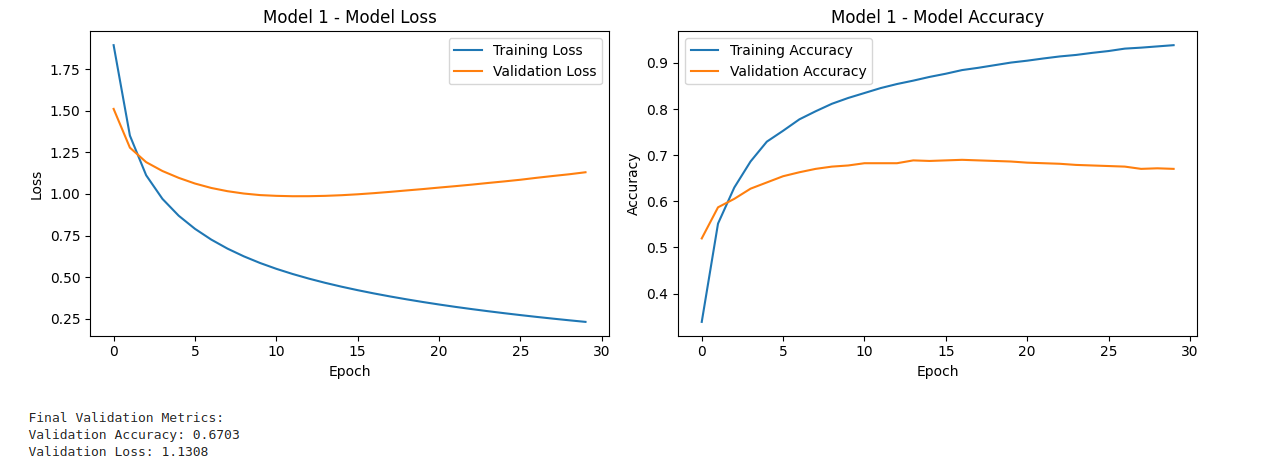

In [18]:
from IPython.display import Image, display

display(Image(filename='ML1_relu.png'))

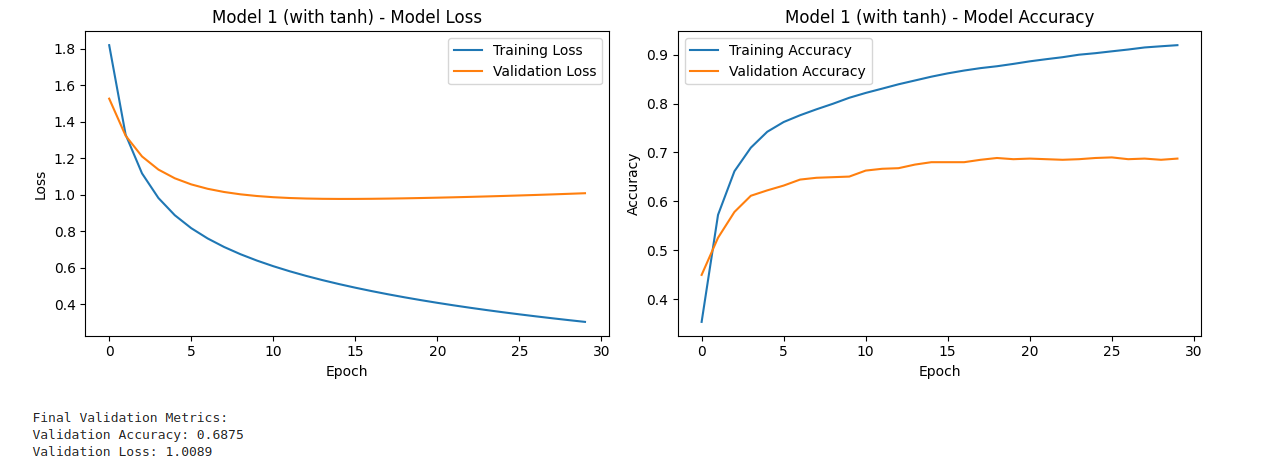

In [19]:
display(Image(filename='ML1_tanh.png'))

### 3.3. Training strategies <a name="mlp_training"></a>
[[go back to the top]](#contents)

After experimenting with **various optimizers** (SGD, RMSprop, Adadelta), we found that the Adam optimizer provided the most consistent performance for our urban sound classification task. Initially, we tested Adam with a **learning rate of 0.001**, which led to observable **overfitting**, as indicated by an increasing gap between training and validation performance.

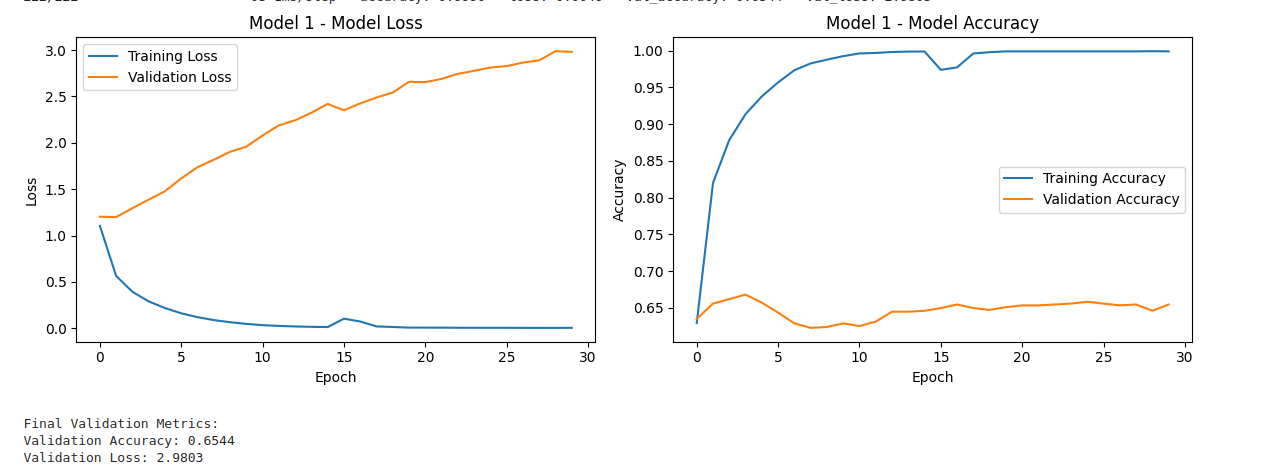

In [21]:
display(Image(filename='ML1_lr_problem.png'))

To address this issue, we reduced the learning rate to **0.0001**, which yielded significantly better results. This lower learning rate allowed the model to converge more slowly but more steadily, resulting in:
- Better generalization performance
- Reduced gap between training and validation metrics
- More stable learning curves
- Improved validation accuracy

We also conducted experiments with different **batch sizes** (32, 64, and 128). The batch size of **128** seemed to provide the best results.

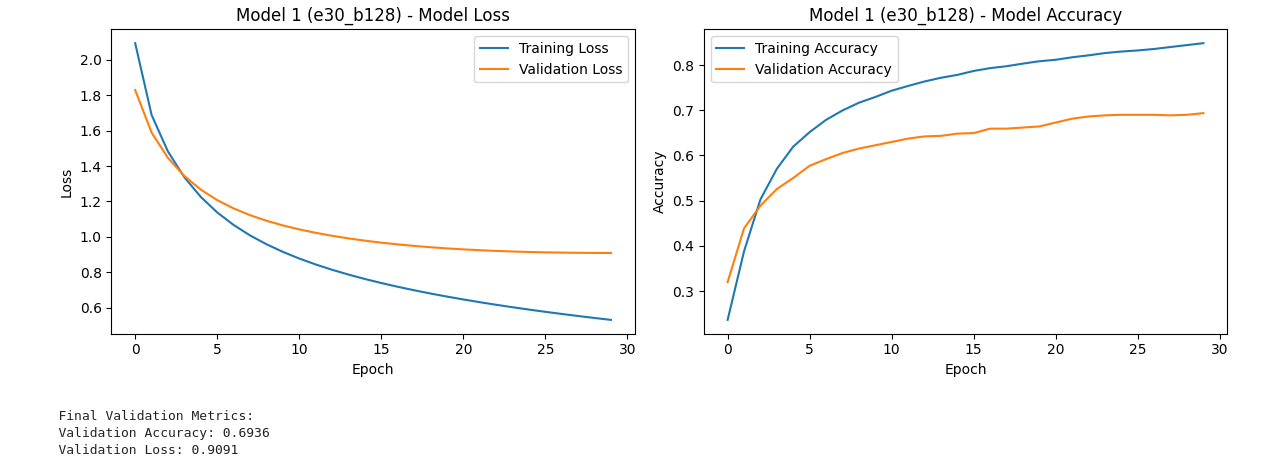

In [23]:
display(Image(filename='ML1_bs.png'))

Regarding the number of **training epochs**, we initially set it to **30** and later experimented with 50 epochs. However, we observed no significant improvement in model performance beyond 30 epochs, suggesting that the model had already converged to a stable solution. 

We have also implemented the following strategies:

**L2 Regularization** (kernel_regularizer=l2(0.001)):
- Applied to both hidden layers

**Progressive Dropout**:
- First layer: 20% dropout (Dropout(0.2))
- Second layer: 10% dropout (Dropout(0.1))

This configuration aimed to balance model capacity with regularization, addressing the overfitting we observed in earlier experiments. The L2 penalty and dropout rates were chosen to significantly constrain the model's ability to memorize training data while maintaining its capacity to learn meaningful audio features.

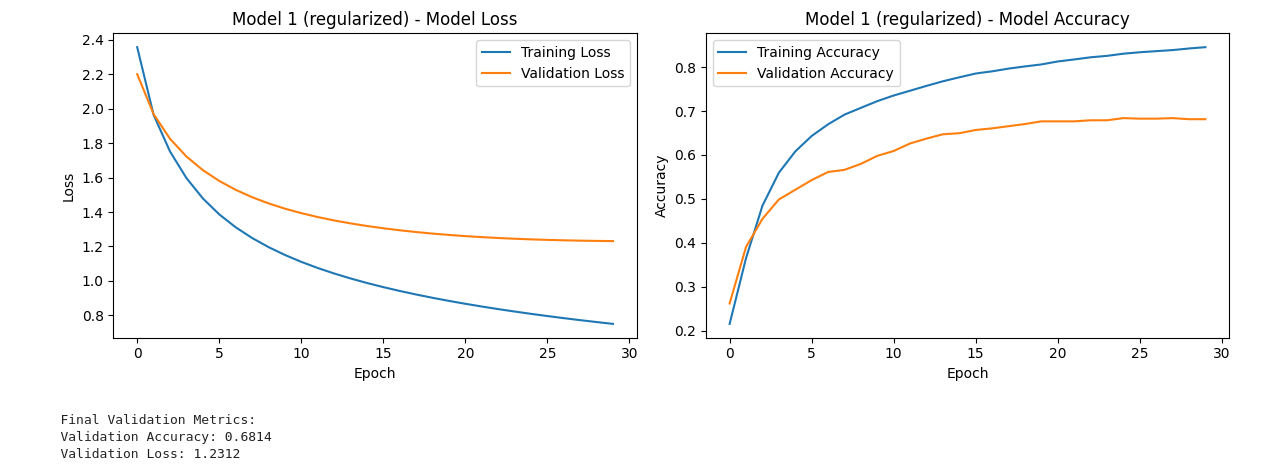

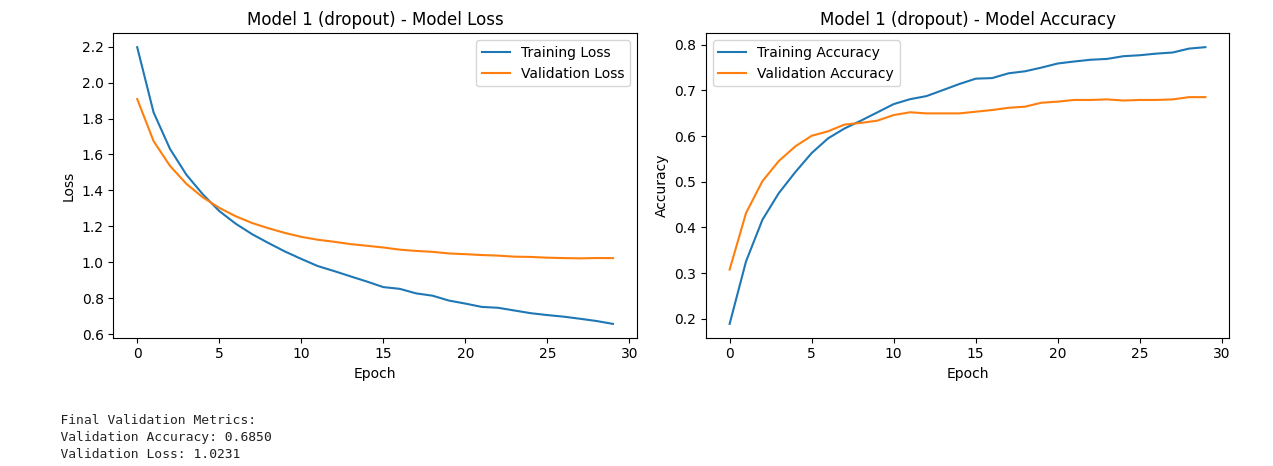

In [24]:
display(Image(filename='ML1_reg.png'))
display(Image(filename='ML1_drop.png'))

However, no significant improvement was noticed when applying these regularization techniques. In fact, both L2 regularization and dropout **slightly decreased** the model's performance, with validation accuracies of 68.14% and 68.50% respectively, compared to 69.36% in the base model. While these techniques helped reduce the gap between training and validation metrics, they also seemed to constrain the model's capacity to learn useful patterns.

After observing potential overfitting in our previous experiments, we implemented **early stopping** with a patience of 5 epochs, monitoring the validation loss and automatically restoring the best weights. This allowed us to extend our training to **100 epochs** without the risk of performance degradation, as the model would automatically stop training when no improvement was observed in the validation metrics for 5 consecutive epochs.

### 3.4. Performance evaluation <a name="mlp_performance"></a>
[[go back to the top]](#contents)

In [30]:
def load_and_prepare_data():
    """Load features and labels from saved CSV files."""
    features = []
    labels = []

    for fold in range(1, 11):
        data = pd.read_csv(f'features_mlp/fold{fold}_features_normalized.csv')
        features.append(data.iloc[:, :172].values)  # First 172 columns are features
        labels.append(data['label'].values)

    return features, labels

In [33]:
def evaluate_model(model_function, features, labels, model_name="Model", num_folds=10, epochs=100, batch_size=128, seed=42):
    """
    Evaluate a model using k-fold cross-validation and return performance metrics including confusion matrix.
    """  
    accuracies = []
    histories = []
    class_names = ["AC", "CH", "CP", "DB", "DR", "EI", "GS", "JA", "SI", "SM"]
    cumulative_conf_matrix = np.zeros((10, 10))
    
    # Cross-validation loop
    for i in range(num_folds):
        print(f"\nTraining {model_name} - Fold {i+1}/{num_folds}")
        # Clear previous session and set random seeds
        tf.keras.backend.clear_session()
        tf.random.set_seed(seed)

        early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
        
        # Define train, validation and test sets for this iteration
        test_fold = i
        val_fold = (i + 1) % num_folds
        train_folds = [f for f in range(num_folds) if f not in [test_fold, val_fold]]
        
        # Combine training data (8 folds)
        train_features = np.concatenate([features[f] for f in train_folds])
        train_labels = np.concatenate([labels[f] for f in train_folds])
        
        # Get validation data (1 fold)
        val_features = features[val_fold]
        val_labels = labels[val_fold]
        
        # Get test data (1 fold)
        test_features = features[test_fold]
        test_labels = labels[test_fold]
        
        # Create and train model
        model = model_function(train_features.shape[1])
        
        # Train using validation data
        history = model.fit(
            train_features, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_features, val_labels),
            callbacks=[early_stopping],  # Add this line
            verbose=0
        )
        histories.append(history.history)
        
        # Get predictions for confusion matrix
        predictions = np.argmax(model.predict(test_features), axis=1)
        
        # Compute confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(test_labels, predictions, labels=range(10))
        cumulative_conf_matrix += fold_conf_matrix
        
        # Calculate and store accuracy
        test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)
        accuracies.append(test_accuracy)
        
        print(f"Fold {i+1} Accuracy: {test_accuracy:.4f}")
    
    # Calculate final metrics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    print(f"\n{model_name} Final Results:")
    print(f"Mean accuracy: {mean_accuracy:.4f}")
    print(f"Std accuracy: {std_accuracy:.4f}")
    
    # Print raw numbers matrix
    print("\nRaw Counts Confusion Matrix:")
    plt.figure(figsize=(12, 10))
    sns.heatmap(cumulative_conf_matrix, annot=True, fmt="g", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Cumulative Confusion Matrix (Raw Counts)")
    plt.tight_layout()
    plt.show()

    # Create normalized confusion matrix (percentages by row)
    row_sums = cumulative_conf_matrix.sum(axis=1)
    normalized_conf_matrix = (cumulative_conf_matrix.T / row_sums).T * 100

    # Plot normalized confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(normalized_conf_matrix, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Normalized Confusion Matrix (% by row)")
    plt.tight_layout()
    plt.show()

    # Analyze confusion patterns
    print("\nAnalyzing Confusion Patterns:")
    
    def analyze_confusions(normalized_conf_matrix, class_names, threshold=10):
        """Analyze which classes are commonly confused with each other"""
        print(f"\nMost Common Confusions (>{threshold}%):")
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                if i != j and normalized_conf_matrix[i][j] > threshold:
                    print(f"{class_names[i]} confused with {class_names[j]}: {normalized_conf_matrix[i][j]:.1f}%")
    
    # Create confusion matrix without diagonal
    confusion_no_diagonal = normalized_conf_matrix.copy()
    np.fill_diagonal(confusion_no_diagonal, 0)  # Set diagonal to 0 to focus on confusions
    
    # Plot heatmap without diagonal
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_no_diagonal, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{model_name} - Confusion Matrix (% by row, diagonal removed)")
    plt.tight_layout()
    plt.show()
    
    # Run confusion analysis
    analyze_confusions(normalized_conf_matrix, class_names, threshold=10)
    
    # Print per-class metrics
    print("\nPer-class Performance:")
    for i, class_name in enumerate(class_names):
        true_positives = cumulative_conf_matrix[i, i]
        total_actual = np.sum(cumulative_conf_matrix[i, :])
        accuracy = true_positives / total_actual if total_actual > 0 else 0
        print(f"{class_name}: Accuracy = {accuracy:.4f} (Total samples: {total_actual})")
    
    return {
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'histories': histories,
        'accuracies': accuracies,
        'confusion_matrix': cumulative_conf_matrix,
        'normalized_confusion_matrix': normalized_conf_matrix,
        'confusion_no_diagonal': confusion_no_diagonal
    }


Training Model 1 - Fold 1/10
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 Accuracy: 0.6369

Training Model 1 - Fold 2/10
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 Accuracy: 0.6092

Training Model 1 - Fold 3/10
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 3 Accuracy: 0.5892

Training Model 1 - Fold 4/10
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 Accuracy: 0.6697

Training Model 1 - Fold 5/10
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 Accuracy: 0.6731

Training Model 1 - Fold 6/10
Epoch 35: early stopping
Restoring model weights from the end of the best epoch

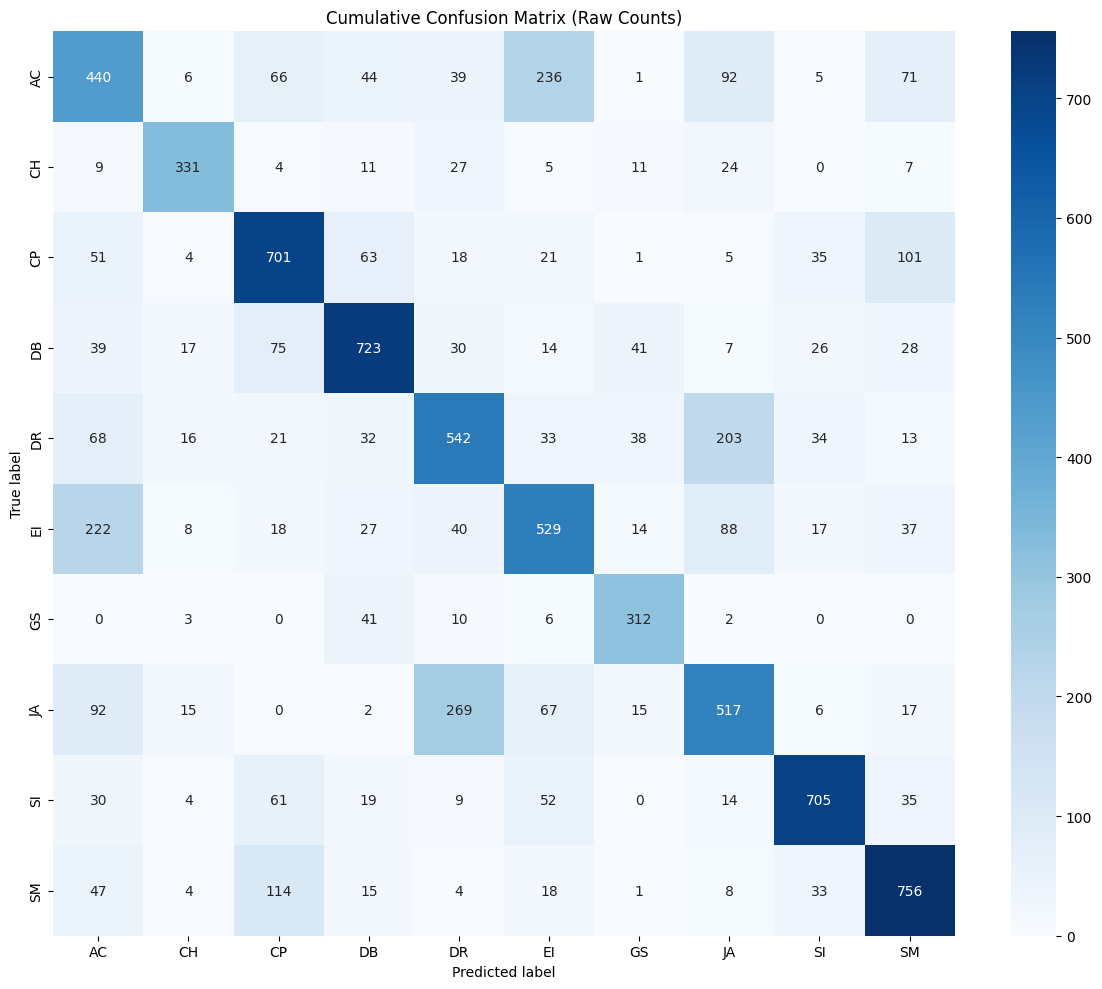

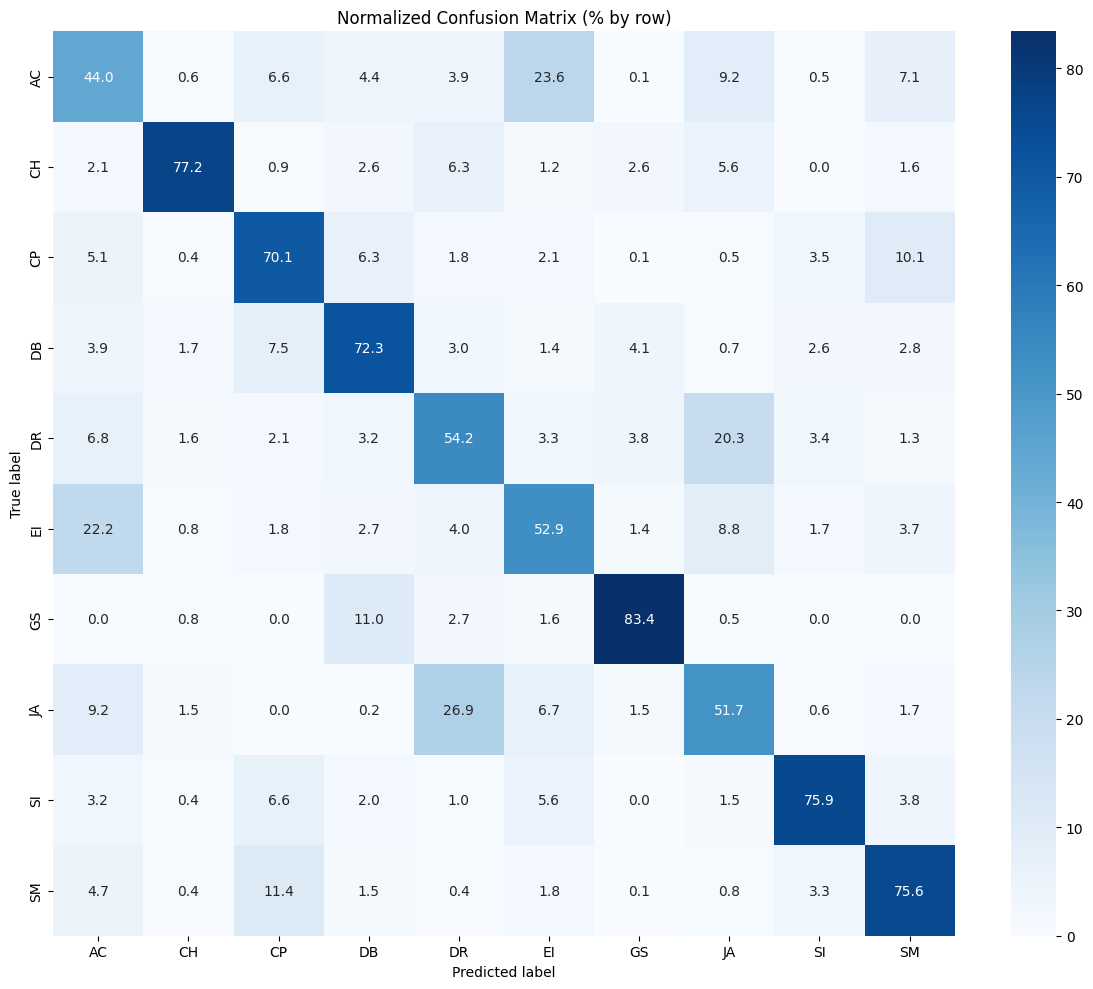


Analyzing Confusion Patterns:


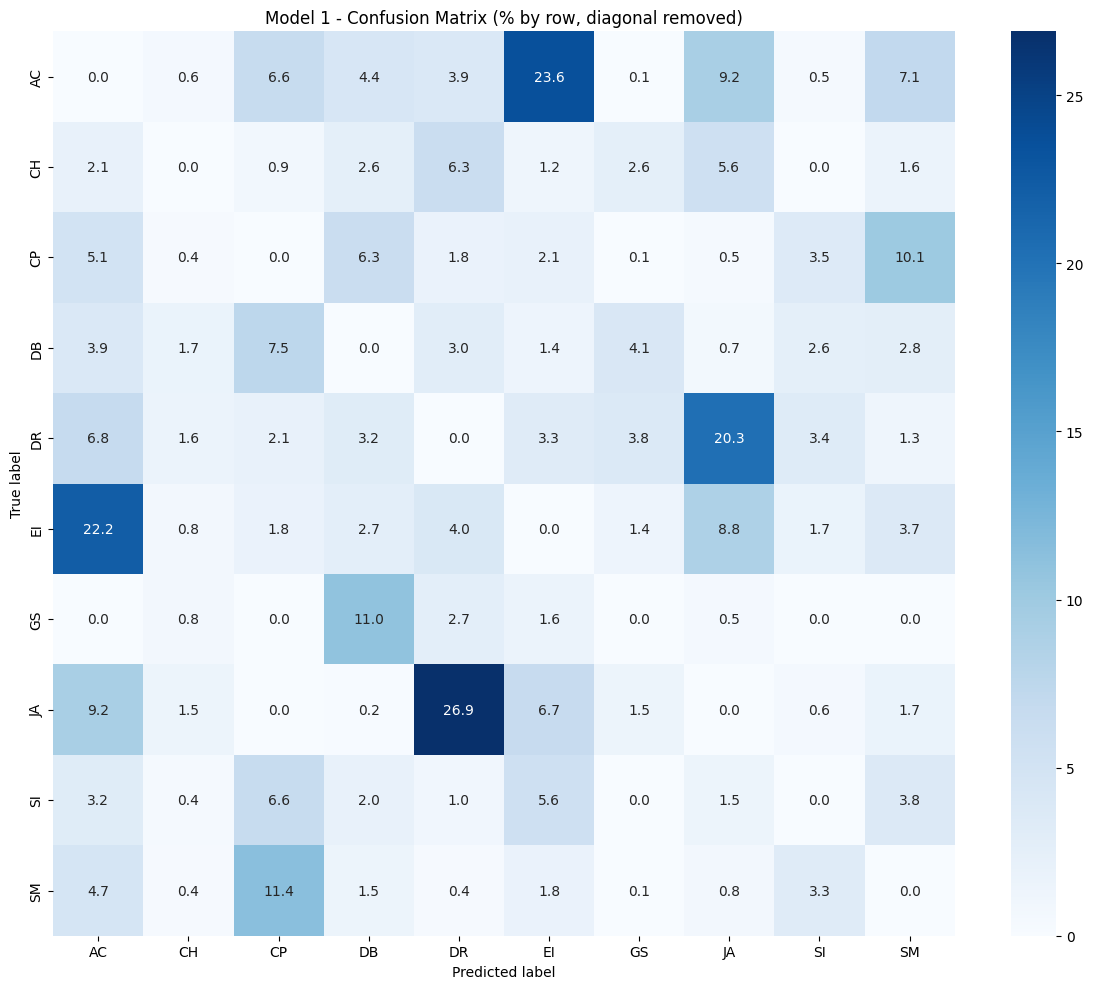


Most Common Confusions (>10%):
AC confused with EI: 23.6%
CP confused with SM: 10.1%
DR confused with JA: 20.3%
EI confused with AC: 22.2%
GS confused with DB: 11.0%
JA confused with DR: 26.9%
SM confused with CP: 11.4%

Per-class Performance:
AC: Accuracy = 0.4400 (Total samples: 1000.0)
CH: Accuracy = 0.7716 (Total samples: 429.0)
CP: Accuracy = 0.7010 (Total samples: 1000.0)
DB: Accuracy = 0.7230 (Total samples: 1000.0)
DR: Accuracy = 0.5420 (Total samples: 1000.0)
EI: Accuracy = 0.5290 (Total samples: 1000.0)
GS: Accuracy = 0.8342 (Total samples: 374.0)
JA: Accuracy = 0.5170 (Total samples: 1000.0)
SI: Accuracy = 0.7589 (Total samples: 929.0)
SM: Accuracy = 0.7560 (Total samples: 1000.0)


In [34]:
features, labels = load_and_prepare_data()

results = evaluate_model(create_model, features, labels, "Model 1")

**Overall Performance**:
- The model achieved varying accuracies across different sound classes, with an overall mean accuracy around 63%
- Performance consistency is reasonable, as shown by the accuracy distribution across classes

**Best Performing Classes**:
- Gun Shot (GS): 83.42% accuracy, showing strong discrimination
- Siren (SI): 75.89% accuracy, likely due to distinctive sound patterns
- Car Horn (CH): 77.16% accuracy, suggesting clear acoustic characteristics

**Challenging Classes**:
- Air Conditioner (AC): 44.00% accuracy, the lowest among all classes
- Jackhammer (JA): 53.60% accuracy, showing significant confusion patterns

**Common Confusion Patterns**:
- Jackhammer (JA) with Drilling (DR): 26.9% confusion rate
- Air Conditioner (AC) with Engine Idling (EI): 23.6%
- Drilling (DR) with Jackhammer (JA): 20.3%
- Engine Idling (EI) with Air Conditioner (AC): 22.2%

**Notable Pattern**:
- Mechanical sounds (JA, DR, AC, EI) tend to be confused with each other
- Children Playing (CP) and Street Music (SM) show mutual confusion (11.4% and 10.1%), likely due to overlapping acoustic features

These results indicate that while the model performs well for distinctive sounds like gunshots, sirens and car horns, it **struggles with mechanically similar sounds**. The confusion patterns suggest that **additional feature engineering** or **data augmentation** focusing on distinguishing mechanical sounds could improve performance.